In [2]:
pacman::p_load(ggplot2,dplyr,tidyr,data.table,stats,
               vegan,ggpubr,corrplot,Hmisc,GGally,
               igraph,network, sna, wesanderson,dils,
               RColorBrewer,data.table,dtplyr,cowplot,tibble,
               ggforce,ggnewscale,philentropy,ggdendro)

In [3]:
devtools::install_github("briatte/ggnet")
library(ggnet)

Skipping install of 'ggnet' from a github remote, the SHA1 (da9a7cf2) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘ggnet’


The following objects are masked from ‘package:GGally’:

    ggnet, ggnet2




Read and format taxonomy information from `EUKulele` and `mmseqs`.

In [4]:
eukaryotic_taxonomy = data.frame(fread(file.path("..","data",
                                                 "2021-marzoanmmetsp-estimated-taxonomy.csv"))) %>%
            dplyr::filter(taxonomy != '-;-;-;-;-;-') %>% separate(taxonomy, sep = ";",
                                     c("Domain","Supergroup","Phylum","Class",
                                       "Order","Family","Genus","Species")) %>%
            dplyr::mutate_all(as.character) %>%
            dplyr::mutate(mag = trimws(mag))
prokaryotic_taxonomy = data.frame(fread(file.path("..","data","prokaryote_taxonomy.csv")))%>% 
                        tidyr::separate(classification,sep=";",
                                        c("Domain","Phylum","Class",
                                          "Order","Family","Genus",
                                          "Species"))
mmseqs_tax = read.csv(file.path("..","data","mmseqs-taxonomy.tsv"),
                         sep='\t', row.names=1) %>%
    dplyr::rename(c("Clade"="clade","Kingdom"="kingdom","Phylum"="phylum",
                    "Class"="class","Order"="order","Family"="family",
                    "Genus"="genus","Species"="species"))
mmseqs_tax$Genome = rownames(mmseqs_tax)
row.names(mmseqs_tax) <- NULL 
mmseqs_tax = mmseqs_tax %>% dplyr::mutate_all(as.character) %>%
    dplyr::mutate(Genome = trimws(Genome))
full_taxonomy = mmseqs_tax %>% dplyr::left_join(eukaryotic_taxonomy,by=c("Genome"="mag")) %>%
    dplyr::mutate(Phylum = case_when(Phylum.x == Phylum.y ~ Phylum.x,
                                     ((Phylum.x == "-")  | (Phylum.x == ".") | (is.na(Phylum.x))) ~ Phylum.y,
                                     ((Phylum.y == "-")  | (Phylum.y == ".") | (is.na(Phylum.y))) ~ Phylum.x,
                                     TRUE ~ Phylum.x),
                  Class = case_when(Class.x == Class.y ~ Class.x,
                             ((Class.x == "-") | (Class.x == ".") | (is.na(Class.x))) ~ Class.y,
                             ((Class.y == "-") | (Class.y == ".") | (is.na(Class.y))) ~ Class.x,
                             TRUE ~ Class.x),
                  Order = case_when(Order.x == Order.y ~ Order.x,
                             ((Order.x == "-")  | (Order.x == ".") | (is.na(Order.x))) ~ Order.y,
                             ((Order.y == "-")  | (Order.y == ".") | (is.na(Order.y))) ~ Order.x,
                             TRUE ~ Order.x),
                  Family = case_when(Family.x == Family.y ~ Family.x,
                             ((Family.x == "-")  | (Family.x == ".") | (is.na(Family.x))) ~ Family.y,
                             ((Family.y == "-")  | (Family.y == ".") | (is.na(Family.y))) ~ Family.x,
                             TRUE ~ Family.x),
                  Genus = case_when(Genus.x == Genus.x ~ Genus.x,
                             (Genus.x == "-")  | (Genus.x == ".") | (is.na(Genus.x)) ~ Genus.y,
                             (Genus.y == "-")  | (Genus.x == ".") | (is.na(Genus.y)) ~ Genus.x,
                             TRUE ~ Genus.x),
                  Species = case_when(Species.x == Species.y ~ Species.x,
                             (Species.x == "-")  | (Species.x == ".") | (is.na(Species.x)) ~ Species.y,
                             (Species.y == "-")  | (Species.y == ".") | (is.na(Species.y)) ~ Species.x,
                             TRUE ~ Species.x)) %>%
    dplyr::select(-c(Phylum.x,Phylum.y,Class.x,Class.y,Order.x,Order.y,Family.x,Family.y,Genus.x,
                    Genus.y,Species.x,Species.y)) %>%
    dplyr::full_join(prokaryotic_taxonomy,by=c("Genome","Domain","Phylum","Class",
                                               "Order","Family","Genus","Species")) %>%
    dplyr::distinct(Genome,.keep_all=T)

#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_euk_prok <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    return(modified_df)
}


#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_tax_string <- function(genome_names,cluster_groups=cluster_groups) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(cluster_groups %>%
                         dplyr::distinct(Cluster, .keep_all = T),by=c("Genome"="Cluster")) %>%
        dplyr::mutate(Genome = case_when(is.na(Genome)|(grepl("Cluster",Genome)) ~ MAG,
                                          TRUE ~ Genome)) %>%
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    tax_cols = c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species")
    modified_df = modified_df %>% unite("tax_combo", all_of(tax_cols), sep=";",remove = TRUE)
    return(modified_df$tax_combo)
}

#' Combine the cluster names and sort them so that we don't have duplicates based on cluster
#' member ordering.
#' Author: Arianna Krinos -----------------
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 650 rows [2, 6, 11, 17, 18, 22, 39, 51, 53, 86, 92, 103, 111, 122, 123, 124, 131, 133, 137, 138, ...].”


Read in the correlations calculated in the Python script `networkanalysis.py` in the present folder and stored in the `data` folder (but not on GH as they are too large).

In [5]:
# We chose to use the TPM-derived correlations.
combined_graph_tpm = data.frame(fread(file.path("..","data","combined_graph_tpm_fullpval.csv")))
combined_graph_tpm = combined_graph_tpm[combined_graph_tpm$pval < (1-(1-0.05)**(1/nrow(combined_graph_tpm))),]

RUN IF YOU DON'T HAVE A COPY OF "igraph_dataframe.csv"

In [9]:
for_igraph = combined_graph_tpm[,colnames(combined_graph_tpm) %in% c("mag1","mag2","corrcoef")]
for_igraph$Link = ""
modified_df = data.frame(Genome = for_igraph$mag1) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
modified_df2 = data.frame(Genome = for_igraph$mag2) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))

for_igraph = for_igraph %>%
    dplyr::mutate(Dom1=as.character(modified_df$EukOrProk),
                  Dom2=as.character(modified_df2$EukOrProk))

for_igraph = for_igraph %>% dplyr::mutate(Link = case_when((Dom1 == "prok") & (Dom2 == "euk") ~ "Euk-Prok",
                                               (Dom2 == "prok") & (Dom1 == "euk") ~ "Euk-Prok",
                                               (Dom1 == "prok") & (Dom2 == "prok") ~ "Prok-Prok",
                                               (Dom1 == "euk") & (Dom2 == "euk") ~ "Euk-Euk",
                                               TRUE ~ "Other"))
write.csv(for_igraph,"igraph_dataframe.csv")

RUN EACH TIME

In [74]:
for_igraph = read.csv("igraph_dataframe.csv")

In [75]:
##### FILTER CANDIDATES BASED ON BUSCO COMPLETENESS #####
busco_completeness = data.frame(fread(file.path("..","data","EUK_BUSCO_CC.csv")))
for_igraph_buscofilt = for_igraph %>% dplyr::left_join(busco_completeness, by = c("mag1" = "V1")) %>%
    dplyr::left_join(busco_completeness, by = c("mag2" = "V1")) %>%
    dplyr::filter((Completeness.x > 30) | (is.na(Completeness.x))) %>%
    dplyr::filter((Completeness.y > 30) | (is.na(Completeness.y)))

First, we'll reduce the total number of MAGs according to those that have >99% pairwise ANI score plus a high degree of correlation with one another, targeting the upper right corner of the ANI graph in the supplement. Next, we cut out the links in the network between eukaryotes that are of a substantially high ANI score + have a pairwise score that's high. We'll set the pairwise score as >99% and the correlation score as >0.7.

In [76]:
##### REFACTOR BY HIGHLY SELF-SIMILAR MAGS PER ANI #####
tara_ani = read.csv(file.path("..","data","all-alex-v-alex.fastani.out"), sep = "\t", header = FALSE)
colnames(tara_ani) = c("i","j","pairwisescore","col4","col5")

tara_ani$i = as.character(tara_ani$i)
tara_ani$j = as.character(tara_ani$j)
cc       <- strsplit(tara_ani$i,'\\.')
part1    <- unlist(cc)[2*(1:length(tara_ani$i))-1]

tara_ani$i = part1
cc       <- strsplit(tara_ani$j,'\\.')
part1    <- unlist(cc)[2*(1:length(tara_ani$j))-1]
tara_ani$j = part1

cc       <- strsplit(tara_ani$i,'/')
part1    <- unlist(cc)
tara_ani$i  <- as.character(filter(data.frame("Part1" = part1), grepl(paste("_bin", collapse="|"), Part1))[,1])

cc       <- strsplit(tara_ani$j,'/')
part1    <- unlist(cc)
tara_ani$j  <- as.character(filter(data.frame("Part1" = part1), grepl(paste("_bin", collapse="|"), Part1))[,1])

edge_by_ani = for_igraph_buscofilt %>% dplyr::filter(Link == "Euk-Euk") %>% 
    dplyr::left_join(tara_ani, by = c("mag1" = "i", "mag2" = "j"))

for_igraph_buscofilt_all = for_igraph_buscofilt %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))

for_igraph_buscofilt = for_igraph_buscofilt %>% dplyr::filter((Link == "Euk-Prok") | (Link == "Euk-Euk")) %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))


##### Find the links that fit these criteria per ANI and create an alias for these closely-related MAGs. #####
cluster_groups = data.frame("MAG"=c(""), "Cluster"=c(0))
cluster_counter = 1
meet_criteria = edge_by_ani %>% dplyr::filter((pairwisescore > 99) & (corrcoef > 0.504))
meet_criteria = meet_criteria %>% dplyr::rename(c("from"="mag1","to"="mag2"))
for (curr in unique(meet_criteria$to)) {
    from_mags = (meet_criteria %>% dplyr::filter(to == curr))$from
    existing_clusters = (cluster_groups %>% dplyr::filter(MAG %in% from_mags))$Cluster
    if (length(existing_clusters) > 0) {
        curr_cluster = min(existing_clusters)
    } else {
        curr_cluster = cluster_counter
        cluster_counter = cluster_counter + 1
    }
    new_clusters = data.frame("MAG" = c(curr,from_mags), 
                              "Cluster" = rep(as.numeric(curr_cluster),length(from_mags) + 1))
    cluster_groups = cluster_groups %>% dplyr::bind_rows(new_clusters)
    cluster_groups$Cluster[cluster_groups$Cluster %in% existing_clusters] = curr_cluster
}
cluster_groups = cluster_groups %>% distinct(Cluster, MAG, .keep_all = TRUE) %>% dplyr::filter(MAG != "")
cluster_groups$MAG = as.character(cluster_groups$MAG)
cluster_groups$Cluster = paste0("Cluster_",cluster_groups$Cluster)
cluster_groups$classification = get_tax_string(cluster_groups$MAG,cluster_groups)

In [77]:
reclustered_network = for_igraph_buscofilt %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(corrcoef > 0.5) %>%
    dplyr::filter(from != to) 
reclustered_network$Domain_to[is.na(reclustered_network$Domain_to)] = "Bacteria"
reclustered_network$Domain_from[is.na(reclustered_network$Domain_from)] = "Bacteria"

In [78]:

reclustered_network = for_igraph_buscofilt %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(corrcoef > 0.5) %>%
    dplyr::filter(from != to) 
reclustered_network$Domain_to[is.na(reclustered_network$Domain_to)] = "Bacteria"
reclustered_network$Domain_from[is.na(reclustered_network$Domain_from)] = "Bacteria"

reclustered_network_allconnections = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt_all$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt_all$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(from != to) 
reclustered_network_allconnections$Domain_to[is.na(reclustered_network_allconnections$Domain_to)] = "Bacteria"
reclustered_network_allconnections$Domain_from[is.na(reclustered_network_allconnections$Domain_from)] = "Bacteria"

write.csv(reclustered_network_allconnections,file.path("..","data","reclustered_net_all.csv"))
write.csv(reclustered_network_allconnections,file.path("..","data","reclustered_net_all.csv"))

In [10]:
reclustered_network_allconnections = data.frame(fread(file.path("..","data","reclustered_net_all.csv")))

SUPPLEMENTARY FIGURES : ANI clustering justification

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


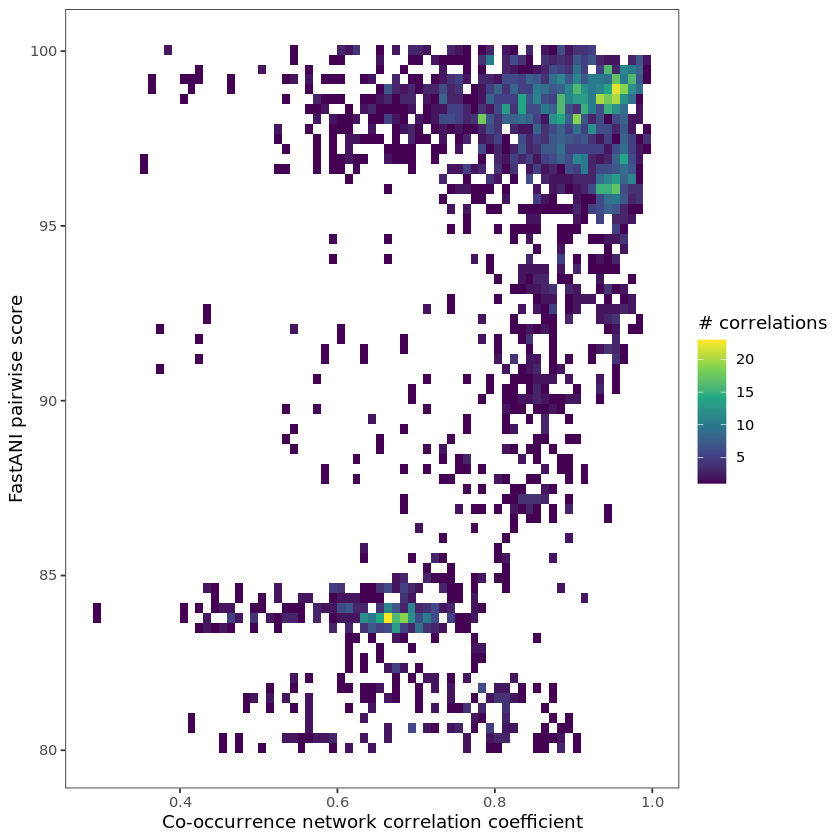

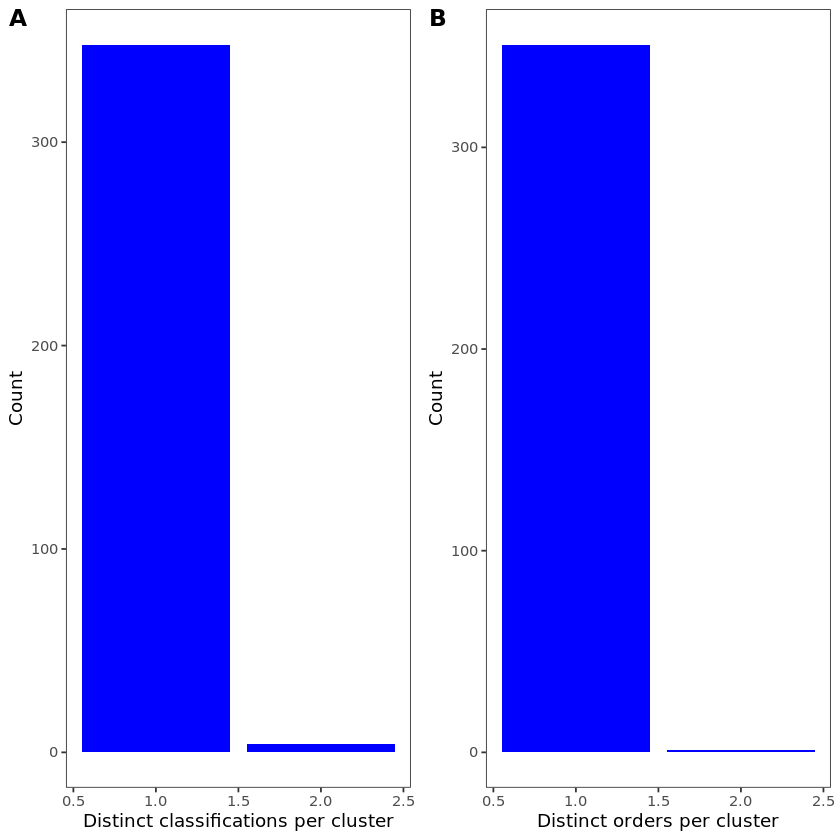

In [79]:
##### CREATE ANI FIGURE #####
ani_plot = ggplot(edge_by_ani %>% dplyr::filter((pairwisescore > 80) & (corrcoef != 1))) +
    geom_bin2d(aes(x = corrcoef, y = pairwisescore), bins = 70) +
    scale_fill_continuous(type = "viridis", name = "# correlations") +
    theme_test() + 
    xlab("Co-occurrence network correlation coefficient") +
    ylab("FastANI pairwise score")
#ggsave(plot=ani_plot, file.path("ani_justification.png"), 
#       dpi=300, width = 6, height = 4, units = "in")
ani_plot

##### CREATE FIGURE TO JUSTIFY THAT CLUSTERS ARE SIMILAR IN TERMS OF TAX COMPOSITION #####
distinct_classifications = cluster_groups %>% distinct(Cluster, classification, .keep_all = TRUE) %>% 
                            separate(classification, sep = ";",
                                     c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"))
distinct_orders = cluster_groups %>% distinct(Cluster, classification, .keep_all = TRUE) %>% 
                            separate(classification, sep = ";",
                                     c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species")) %>%
                  distinct(Cluster, Order, .keep_all = TRUE)

distinct_classes = ggplot(distinct_classifications %>% 
                          dplyr::group_by(Cluster) %>% dplyr::summarize(Count = n())) +
    geom_histogram(aes(x=Count),fill="blue",stat="count") + theme_test() + ylab("Count") +
    xlab("Distinct classifications per cluster")

distinct_orders = ggplot(distinct_orders %>% dplyr::group_by(Cluster) %>% 
                         dplyr::summarize(Count = n())) +
    geom_histogram(aes(x=Count),fill="blue",stat="count") + theme_test() + ylab("Count") +
    xlab("Distinct orders per cluster")

distinct_classifications = cowplot::plot_grid(distinct_classes,distinct_orders,labels=c("A","B"))
ggsave(plot=cowplot::plot_grid(distinct_classifications,ani_plot,ncol=2),
       file.path("..","si-figures","clustering_justification.png"),
       dpi=300, width = 6, height = 3, units = "in")
distinct_classifications

Now let's generate our actual network figures!

In [80]:
df_graph <- reclustered_network %>% 
            dplyr::select(to,from,corrcoef,Link,Dom1,Dom2)%>%
            dplyr::filter(corrcoef > 0.7)
refactored_graph <- graph_from_data_frame(df_graph,
                                          directed = FALSE, vertices = NULL)

corr_communities <- cluster_louvain(refactored_graph,weight=df_graph$corrcoef)

set_vertex_attr(refactored_graph, "clustermembership",
                index = V(refactored_graph),
                membership(corr_communities))
set_vertex_attr(refactored_graph, "classification",
                index = V(refactored_graph),
                get_tax_string(V(refactored_graph)$name,cluster_groups))

layout_gr <- get.data.frame(refactored_graph) 

IGRAPH 819b248 UN-- 541 17736 -- 
+ attr: name (v/c), clustermembership (v/n), corrcoef (e/n), Link
| (e/c), Dom1 (e/c), Dom2 (e/c)
+ edges from 819b248 (vertex names):
 [1] Cluster_3                  --Cluster_1
 [2] Cluster_10                 --Cluster_1
 [3] Cluster_18                 --Cluster_1
 [4] Cluster_26                 --Cluster_1
 [5] Cluster_52                 --Cluster_1
 [6] Cluster_57                 --Cluster_1
 [7] Cluster_62                 --Cluster_1
+ ... omitted several edges

IGRAPH 819b248 UN-- 541 17736 -- 
+ attr: name (v/c), classification (v/c), corrcoef (e/n), Link (e/c),
| Dom1 (e/c), Dom2 (e/c)
+ edges from 819b248 (vertex names):
 [1] Cluster_3                  --Cluster_1
 [2] Cluster_10                 --Cluster_1
 [3] Cluster_18                 --Cluster_1
 [4] Cluster_26                 --Cluster_1
 [5] Cluster_52                 --Cluster_1
 [6] Cluster_57                 --Cluster_1
 [7] Cluster_62                 --Cluster_1
+ ... omitted several edges

IGRAPH fef6d26 UN-- 541 7100 -- 
+ attr: name (v/c), clustermembership (v/n), corrcoef (e/n), Link
| (e/c), Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from fef6d26 (vertex names):
 [1] Cluster_295--Cluster_198 Cluster_82 --Cluster_60  Cluster_334--Cluster_241
 [4] Cluster_164--Cluster_143 Cluster_322--Cluster_147 Cluster_217--Cluster_143
 [7] Cluster_348--Cluster_285 Cluster_165--Cluster_146 Cluster_69 --Cluster_37 
[10] Cluster_319--Cluster_60  Cluster_325--Cluster_189 Cluster_325--Cluster_282
[13] Cluster_344--Cluster_186 Cluster_199--Cluster_61  Cluster_337--Cluster_285
[16] Cluster_82 --Cluster_319 Cluster_271--Cluster_143 Cluster_315--Cluster_241
[19] Cluster_199--Cluster_153 Cluster_285--Cluster_183 Cluster_250--Cluster_123
+ ... omitted several edges

IGRAPH fef6d26 UN-- 541 7100 -- 
+ attr: name (v/c), classification (v/c), corrcoef (e/n), Link (e/c),
| Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from fef6d26 (vertex names):
 [1] Cluster_295--Cluster_198 Cluster_82 --Cluster_60  Cluster_334--Cluster_241
 [4] Cluster_164--Cluster_143 Cluster_322--Cluster_147 Cluster_217--Cluster_143
 [7] Cluster_348--Cluster_285 Cluster_165--Cluster_146 Cluster_69 --Cluster_37 
[10] Cluster_319--Cluster_60  Cluster_325--Cluster_189 Cluster_325--Cluster_282
[13] Cluster_344--Cluster_186 Cluster_199--Cluster_61  Cluster_337--Cluster_285
[16] Cluster_82 --Cluster_319 Cluster_271--Cluster_143 Cluster_315--Cluster_241
[19] Cluster_199--Cluster_153 Cluster_285--Cluster_183 Cluster_250--Cluster_123
+ ... omitted several edges

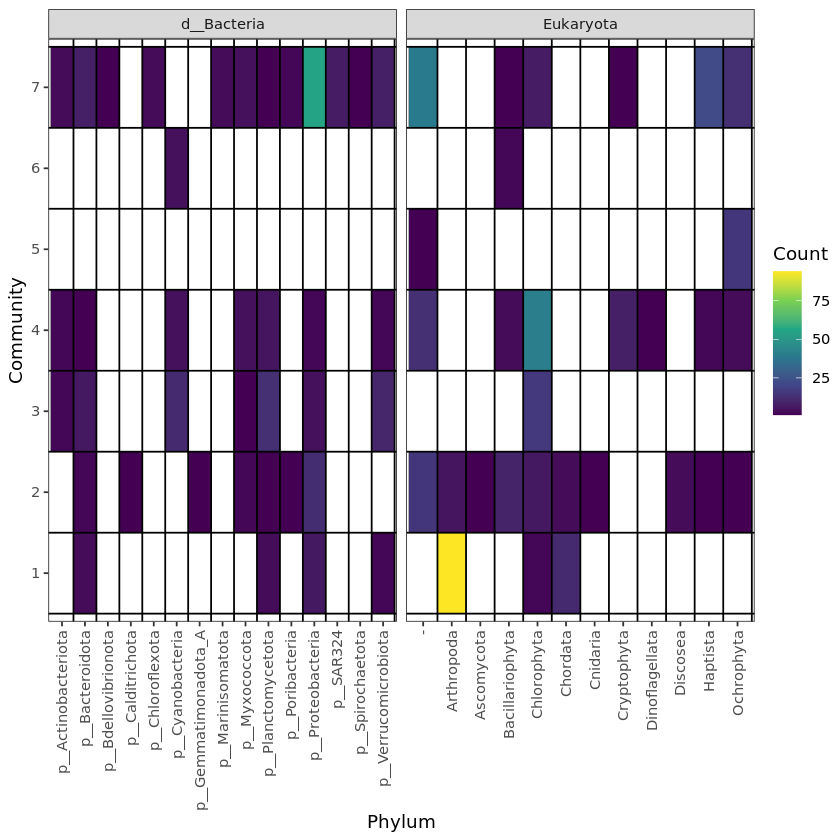

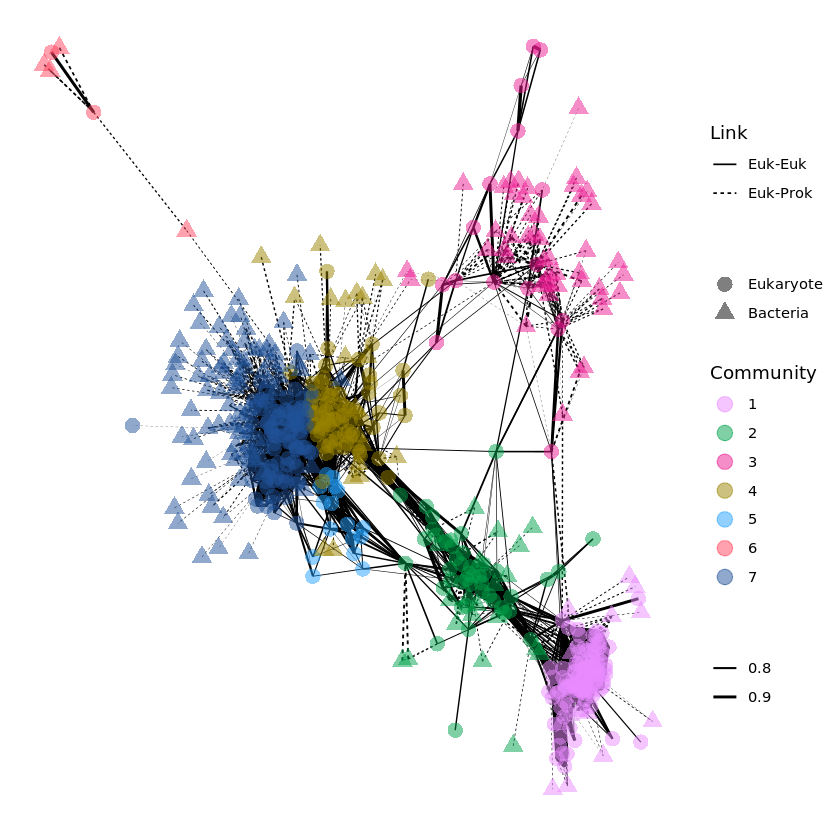

In [89]:
##### GENERATE GRAPH FROM THE REFACTORED NETWORK #####
df_graph <- reclustered_network %>% 
            dplyr::select(to,from,corrcoef,Link,Dom1,Dom2)%>%
            dplyr::filter(corrcoef > 0.7) %>%
            arrange(desc(corrcoef)) %>%
            dplyr::distinct(to,from,Link,Dom1,Dom2,.keep_all=TRUE)
df_graph$combined_clust = get_combo(df_graph)
df_graph <- df_graph %>% dplyr::distinct(combined_clust,.keep_all=TRUE)
refactored_graph <- graph_from_data_frame(df_graph,
                                          directed = FALSE, vertices = NULL)

corr_communities <- cluster_louvain(refactored_graph,weight=df_graph$corrcoef)

set_vertex_attr(refactored_graph, "clustermembership",
                index = V(refactored_graph),
                membership(corr_communities))
set_vertex_attr(refactored_graph, "classification",
                index = V(refactored_graph),
                get_tax_string(V(refactored_graph)$name,cluster_groups))

edge_df <- df_graph

# Create a layout of the graph
layout_gr <- as.data.frame(layout.fruchterman.reingold(refactored_graph))
# Add the MAG labels
layout_gr$mag <- V(refactored_graph)$name

# Add the euk-prok labels
edge_df_inform <- edge_df %>% dplyr::select(from,Dom1) %>% dplyr::rename(c("mag"="from","class"="Dom1")) %>%
                    dplyr::bind_rows(edge_df %>% dplyr::select(to,Dom2) %>% 
                                     dplyr::rename(c("mag"="to","class"="Dom2")))
layout_gr$eukprok <- edge_df_inform$class[match(layout_gr$mag,edge_df_inform$mag)]
layout_gr$classification <- get_tax_string(layout_gr$mag,cluster_groups)
layout_gr$community <- membership(corr_communities)
# manually re-assign communities so we don't have to re-label them after changing
# ANI cutoff
layout_gr = layout_gr %>% dplyr::mutate(community = case_when(community == 1 ~ 7,
                                                              community == 7 ~ 3,
                                                              community == 3 ~ 1,
                                                              community == 4 ~ 5,
                                                              community == 5 ~ 2,
                                                              community == 2 ~ 4,
                                                              community == 6 ~ 6))

layout_gr <- layout_gr %>% 
                    dplyr::mutate("degree" = as.numeric(as.character(igraph::degree(refactored_graph,
                                                                                  v = layout_gr$mag))))

layout_gr = layout_gr %>% dplyr::left_join(cluster_groups,by=c("mag"="Cluster")) %>% 
            dplyr::mutate(classification = case_when((classification.x == "none") ~ classification.y,
                                                     TRUE ~ classification.x)) %>%
            dplyr::select(V1,V2,eukprok,mag,classification,community,degree)
layout_gr <- layout_gr %>% dplyr::distinct()

edge_df$from.x <- layout_gr$V1[match(edge_df$from, layout_gr$mag)]  #  match the from locations from the node data.frame we previously connected
edge_df$from.y <- layout_gr$V2[match(edge_df$from, layout_gr$mag)]
edge_df$to.x <- layout_gr$V1[match(edge_df$to, layout_gr$mag)]  #  match the to locations from the node data.frame we previously connected
edge_df$to.y <- layout_gr$V2[match(edge_df$to, layout_gr$mag)]

layout_gr_classes = layout_gr %>% 
    separate(classification, sep = ";", fill = "left",
                    c("Domain","Clade","Kingdom","Supergroup",
                      "Phylum","Class","Order","Family","Genus","Species"))

##### VISUALIZE TAXONOMIC CLASSES IN EACH COMMUNITY #####
taxon_comm = ggplot(layout_gr_classes) + stat_bin2d(aes(x = Phylum, y = factor(community), fill = after_stat(count)),
                                       colour="black") + 
    facet_wrap(~Domain,scales="free_x") + theme_test() + 
    scale_fill_continuous(na.value = "white", type="viridis", name = "Count") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=seq(1.5, length(unique(layout_gr_classes$Phylum))-0.5, 1), 
             lwd=0.5, colour="black") + 
    geom_hline(yintercept=seq(0.5, length(unique(layout_gr_classes$community))+0.5, 1), 
             lwd=0.5, colour="black") + 
    ylab("Community") + xlab("Phylum")
taxon_comm
ggsave(file.path("..","si-figures","network_70cutoff_phylum.png"),
       dpi=300, width = 6, height = 4, units = "in")

##### PLOT THE NETWORK COMMUNITIES #####
# this is adapted from here https://chrischizinski.github.io/rstats/igraph-ggplotll/
# Plot out the initial layout
n <- length(corr_communities)
palette <- c("#ea8cff","#01a24b","#ec1d92","#998400","#27a3ff",
             "#ff455e","#205297","#ffa56d","#764164","#b5706d")

network_plot = ggplot() +
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
        geom_point(data=layout_gr,aes(x=V1,y=V2,shape=factor(eukprok),
                                      colour=factor(community)),size=4,alpha=0.5) +
        theme_bw() +
        scale_shape(name = "", solid = TRUE, breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
        scale_color_manual(name = "Community", values = palette) + 
        scale_size(range = c(0, 1),labels=c("0.7","0.8","0.9"),breaks=c(0.7,0.8,0.9),name="") + 
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank())
    network_plot

In [90]:
layout_gr_classes %>% dplyr::filter(community == 3) %>% 
    dplyr::filter(Domain == "d__Bacteria") %>% dplyr::group_by(Genus,Phylum,Class,Order) %>% dplyr::tally()

layout_gr_classes %>% dplyr::group_by(community) %>% dplyr::summarize(MeanDegree = mean(degree))

Genus,Phylum,Class,Order,n
<chr>,<chr>,<chr>,<chr>,<int>
g__,p__Cyanobacteria,c__Cyanobacteriia,o__Synechococcales,2
g__,p__Myxococcota,c__UBA796,o__UBA796,1
g__,p__Planctomycetota,c__Phycisphaerae,o__Phycisphaerales,2
g__,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,1
g__,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,1
g__Cognatiyoonia,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,1
g__EC70,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,2
g__GCA-002862325,p__Planctomycetota,c__Phycisphaerae,o__Phycisphaerales,5
g__GCA-2684655,p__Planctomycetota,c__UBA1135,o__UBA2386,1


community,MeanDegree
<dbl>,<dbl>
1,43.429752
2,16.430769
3,5.174603
4,26.670330
5,16.625000
6,1.833333
7,27.078212


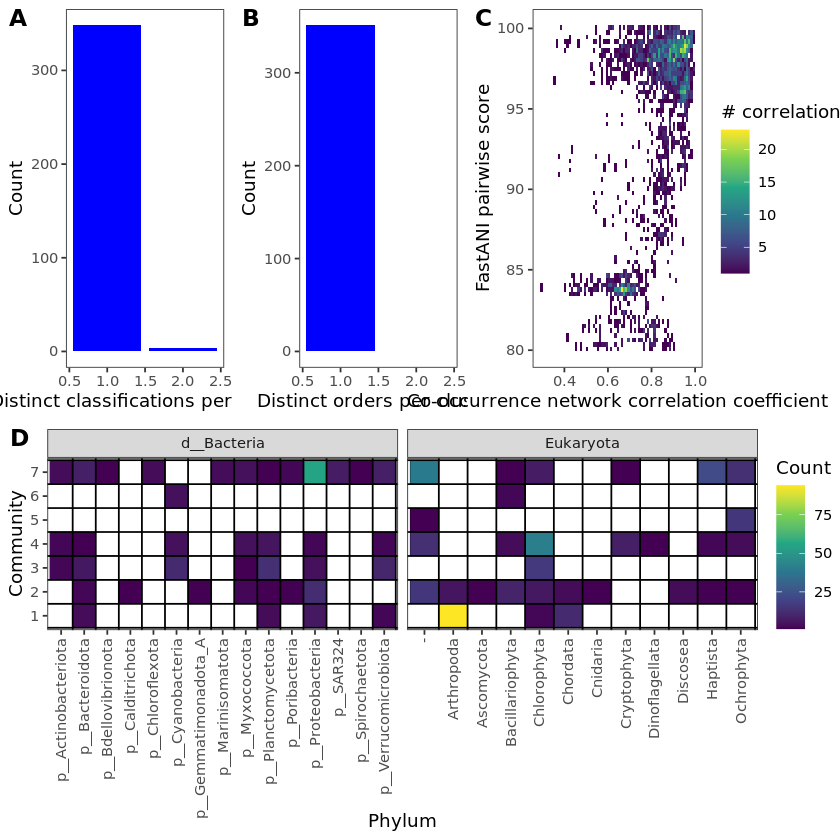

In [91]:
cowplot::plot_grid(cowplot::plot_grid(distinct_classifications,ani_plot
                                      ,rel_widths=c(1,0.8),labels=c("","C")),
                   taxon_comm,ncol=1,labels=c("","D"))
ggsave(file.path("..","si-figures","network_supporting.png"),dpi=350,width=12,height=8,units="in")

In [183]:
write.csv(layout_gr_classes %>% dplyr::select(-c(V1,V2)) %>% 
    dplyr::left_join(cluster_groups, by=c("mag"="Cluster")),file.path("/vortexfs1","omics",
                                                                      "alexander","share",
                                                                      "2021-05-10_mags_communities",
                                                                      "all_mags_communities.csv"))

write.csv(layout_gr_classes %>% dplyr::select(-c(V1,V2)) %>% dplyr::filter(Domain == "d__Bacteria") %>% 
    dplyr::left_join(cluster_groups, by=c("mag"="Cluster")),file.path("/vortexfs1","omics",
                                                                      "alexander","share",
                                                                      "2021-05-10_mags_communities",
                                                                      "prok_mags_communities.csv"))

Read in environmental metadata.

In [52]:
harriet_groups = read.csv("/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/tables/final/TableS2_EukaryoticMAG.csv")
harriet_groups

X,eukulele_taxonomy,mmseqs_taxonomy,groups,total_length,total_num_contigs,total_length_5kb,total_length_10kb,total_length_50kb,GC_percent,⋯,proportion_proteins_annoated_kegg,num_unique_kegg,busco_eukaryota_odb10_completeness,busco_eukaryota_odb10_contamination,eukcc_completeness,eukcc_contamination,eukcc_lineage,ocean_region,depth,size_fraction
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
TOPAZ_IOD1_E001,Eukaryota;Hacrobia;Cryptophyta;Cryptophyceae;Cryptomonadales;-;-;-,Eukaryota;-;-;-;Cryptophyceae;-;Pyrenomonadales;Geminigeraceae;Geminigera cryophila,Cryptophyta,37074820,8377,15520088,2726308,0,58.27,⋯,16.09,2922,57.25,2.75,69.57,8.70,Eukaryota_Fungi_Ascomycota,IO,DCM,0.8-5
TOPAZ_IOD1_E002,Eukaryota;-;-;-;-;-;-;-,Eukaryota;-;Sar;-;-;-;-;-;-,SAR,2801896,851,188909,0,0,44.45,⋯,20.41,842,13.73,0.00,NA,NA,,IO,DCM,0.8-5
TOPAZ_IOD1_E003,Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;-;-;-;-,Eukaryota;-;Prymnesiophyceae;Haptista;Haptophyta;-;Prymnesiales;Prymnesiaceae;Chrysochromulina rotalis,Haptophyta,30740252,7112,12314358,2329232,0,62.86,⋯,13.28,2850,49.41,0.39,52.08,4.17,Eukaryota_Fungi_Microsporidia,IO,DCM,0.8-5
TOPAZ_IOD1_E004,Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;-;-;-;-,Eukaryota;-;Prymnesiophyceae;Haptista;Haptophyta;-;Prymnesiales;Chrysochromulinaceae;Chrysochromulina rotalis,Haptophyta,39191221,9102,15279501,2168595,0,62.08,⋯,13.75,2859,50.98,0.39,NA,NA,,IO,DCM,0.8-5
TOPAZ_IOD1_E005,Eukaryota;Archaeplastida;Chlorophyta;Mamiellophyceae;Mamiellales;Mamiellaceae;Micromonas;Micromonas sp.,Eukaryota;Viridiplantae;-;Chlorophyta;Mamiellophyceae;-;Mamiellales;Mamiellaceae;-,Chlorophyta,17055374,1415,15579731,12443612,1136508,66.20,⋯,34.70,3127,74.90,0.39,94.74,0.00,Eukaryota,IO,DCM,0.8-5
TOPAZ_IOD1_E006,Eukaryota;-;-;-;-;-;-;-,Eukaryota;-;Sar;-;-;-;-;-;-,SAR,6216056,1828,646516,10967,0,58.76,⋯,12.94,956,12.16,0.00,NA,NA,,IO,DCM,0.8-5
TOPAZ_IOD1_E007,Eukaryota;-;-;-;-;-;-;-,Eukaryota;-;-;-;Cryptophyceae;-;Pyrenomonadales;-;-,Cryptophyta,7798024,2202,1200476,75211,0,49.71,⋯,17.44,1181,21.18,0.39,NA,NA,,IO,DCM,0.8-5
TOPAZ_IOD1_E008,Eukaryota;-;-;-;-;-;-;-,Eukaryota;-;Sar;-;-;-;-;-;-,SAR,25519293,5508,11988952,2613370,0,33.14,⋯,20.20,2891,65.49,1.18,NA,NA,,IO,DCM,0.8-5
TOPAZ_IOD1_E009,Eukaryota;Archaeplastida;Chlorophyta;-;-;-;-;-,Eukaryota;Viridiplantae;core chlorophytes;Chlorophyta;-;-;-;-;-,Chlorophyta,11967780,2657,5212218,921112,0,65.22,⋯,36.22,2677,56.47,0.39,63.16,0.00,Eukaryota,IO,DCM,0.8-5


In [92]:
###Read in MAG data
HQ_Mags = read.csv(file.path("..","data","taxonomy_color_ranges.csv"), 
                   row.names=1)
test = HQ_Mags
EukMAGDF = read.csv(file.path("..","tables","final", 
                    'TableS2_EukaryoticMAG.csv'), row.names=1) %>% dplyr::mutate(new_mag_name=row.names(.))
translation_dict = read.csv('/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t', 
                               row.names=1)
translation_dict_r = read.csv('/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t', 
                                 row.names=1)
HQ_Mags = HQ_Mags %>% dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>%
                             mutate(old_mag_name = rownames(.)))
rownames(HQ_Mags) = HQ_Mags$new_mag_name
mmseqs_tax = read.csv(file.path("..","data",'mmseqs-taxonomy.tsv'),
                         sep='\t', row.names=1)
mmseqs_tax = mmseqs_tax %>% dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>%
                             mutate(old_mag_name = rownames(.)))
rownames(mmseqs_tax) = mmseqs_tax$new_mag_name
EukMAGDF['total_length_Mb'] = EukMAGDF$total_length/10^6
# Define broad plotting groups of taxa 
fungi_int = rownames(mmseqs_tax)[which(as.character(mmseqs_tax$kingdom)=='Fungi')]
sar = rownames(mmseqs_tax %>% dplyr::filter((kingdom == ".") & (clade == "Sar") & 
                                            (phylum == ".") & (class == ".")))
harriet_groups = read.csv("/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/tables/final/TableS2_EukaryoticMAG.csv")
harriet_groups = harriet_groups %>% dplyr::select(X,groups) %>% dplyr::rename("harriet_groups"="groups")
EukMAGDF = EukMAGDF %>% #dplyr::mutate(new_mag_name=row.names(.)) %>%
                        dplyr::left_join(mmseqs_tax,by="new_mag_name") %>%
                        tidyr::separate(eukulele_taxonomy,into=c("tax0","tax1","tax2","tax3"),extra="drop",fill="right") %>%
                        tidyr::replace_na(list(tax1 = "-", tax2 = "-")) %>%
                        dplyr::mutate(groups=paste(tax1,tax2,sep=";")) %>%
                        dplyr::select(-c("tax0","tax1","tax2","tax3")) %>%
                        dplyr::mutate(groups_full = as.character(groups)) %>%
                        dplyr::mutate(groups = case_when(kingdom == "Fungi" ~ "Fungi",
                                                         grepl("Metazoa",groups_full) ~ "Metazoa",
                                                         grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                                         grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                                         grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                                         grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                                         (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                                         (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                                         (groups_full == "Stramenopiles;-") ~ "Sar",
                                                         (groups_full == "Stramenopiles;") ~ "Sar",
                                                          grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                                         ((kingdom == ".") & (clade == "Sar") & 
                                                         (phylum == ".") & (class == ".")) ~ "Sar",
                                                         (groups_full == "-;") ~ "Eukaryota",
                                                         (groups_full == "-;-") ~ "Eukaryota",
                                                         (groups_full == ";-") ~ "Eukaryota",
                                                         (clade == "Sar") ~ "Sar")) %>%
                      dplyr::mutate(groups = as.character(groups)) %>%
                      dplyr::left_join(harriet_groups,by = c("new_mag_name"="X")) %>%
                      dplyr::mutate(harriet_groups = as.character(harriet_groups)) %>%
                      dplyr::mutate(groups = case_when((harriet_groups != "") & !is.na(harriet_groups) ~ harriet_groups,
                                                       TRUE ~ groups))
EukMAGDF_HQ_all = EukMAGDF 
#EukMAGDF = EukMAGDF %>% dplyr::left_join(HQ_Mags,by=c("new_mag_name","old_mag_name")) %>% 
#                dplyr::filter(!is.na(color)) %>% distinct(groups,.keep_all=TRUE)
EukMAGDF_HQ = EukMAGDF %>% dplyr::left_join(HQ_Mags,by=c("new_mag_name","old_mag_name")) %>% 
                dplyr::filter(!is.na(color)) %>% distinct(groups,.keep_all=TRUE) %>% 
                mutate(across(everything(), as.character)) %>% 
                bind_rows(data.frame("new_mag_name"="","old_mag_name"="",
                                     "color"=c("#E66B92",'#FCDCFF','#18AB7B','#9A6ACD','#C6BE53'),
                                     "groups"=c('Amoebozoa','Choanozoa','Dinoflagellata',
                                                'Apusozoa','Cryptophyta')))
                #bind_rows(data.frame("new_mag_name"="","old_mag_name"="",
                #                     "color"="#E66B92","groups"='Amoebozoa'))

EukMAGDF = EukMAGDF %>% dplyr::left_join(EukMAGDF_HQ %>% dplyr::select(color,groups))
#Read in pangea data
pangea = read.csv(file.path("..","data",'TARA_sample_enviro.tab'), 
                  sep ='\t', header=TRUE,skip=2508)
colnames(pangea) = c("Sample ID (TARA_barcode#)",
                     "Basis","Campaign","Station (TARA_station#)","Event","Event 2",
                     "Method/Device","Date/Time","Latitude","Longitude","Date/Time 2",
                     "Latitude 2","Longitude 2","Env feature (abbreviation)",
                     "Env feature (full name (ENVO:ID), terms re...)","MP biome (Longhurst (2007))",
                     "OS region ([abbreviation] full name (MRG...)",
                     "BG province ([abbreviation] full name (MRG...)",
                     "Depth ref [m] (in the selected environmental...)",
                     "Cond [mS/cm] (in the selected environmental...)",
                     "Sal (in the selected environmental...)",
                     "Tpot [°C] (in the selected environmental...)",
                     "Sigma-theta [kg/m**3] (in the selected environmental...)",
                     "O2 [µmol/kg] (in the selected environmental...)", 
                     "O2 [µmol/kg] (in the selected environmental...)",
                     "[NO3]- [µmol/l] (in the selected environmental...)",
                     "[NO2]- [µmol/l] (in the selected environmental...)",
                     "[PO4]3- [µmol/l] (in the selected environmental...)",
                     "[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)",
                     "Si(OH)4 [µmol/l] (in the selected environmental...)",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "bb470 [1/m] (in the selected environmental...)",
                     "bbp470 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (in the selected environmental...)",
                     "bac660 [1/m] (in the selected environmental...)",
                     "bacp660 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (at the sampling location, exp...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 30 days aroun...)",
                     "NPP C [mg/m**2/day] (for a period of 8 days around...)",
                     "NPP C [mg/m**2/day] (for a period of 30 days aroun...)",
                     "MLD [m] (in the selected environmental...)",
                     "MLD [m] (in the selected environmental...)",
                     "D chl m [m] (in the selected environmental...)",
                     "Depth max Brunt Väisälä freq [m] (in the selected environmental...)",
                     "Depth max O2 [m] (in the selected environmental...)",
                     "Depth min O2 [m] (in the selected environmental...)",
                     "Depth nitracline [m] (in the selected environmental...)",
                     "Season (spring, summer, autumn, or wi...)",
                     "Season (early, middle, or late)",
                     "Moon phase proportion (indicates if the phase of the...)",
                     "Moon phase proportion (indicates the proportion of i...)",
                     "SSD [min] (day length)",
                     "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "OW (indicates the presence of an ...)",
                     "MLE [1/day] (indicates the presence of a t...)",
                     "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
                     "RT [days] (of the water mass. Values>30 ...)")
colnames(pangea) = c("TaraBarcode",
                     "Basis","Campaign","Station (TARA_station#)","Event","Event 2",
                     "Method/Device","Date/Time","Latitude","Longitude","Date/Time 2",
                     "Latitude 2","Longitude 2","Env feature (abbreviation)",
                     "Env feature (full name (ENVO:ID), terms re...)","MP biome (Longhurst (2007))",
                     "Region",
                     "BG province ([abbreviation] full name (MRG...)",
                     "Depth ref [m] (in the selected environmental...)",
                     "Cond [mS/cm] (in the selected environmental...)",
                     "Sal",
                     "Tpot [°C] (in the selected environmental...)",
                     "Sigma-theta [kg/m**3] (in the selected environmental...)",
                     "O2 [µmol/kg] (in the selected environmental...)",
                     "O2",
                     "Nitrate",
                     "Nitrite",
                     "Phosphate",
                     "Nitrate+Nitrite",
                     "Silica",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "Chla",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)1",
                     "beta470 [m/sr] (in the selected environmental...)2",
                     "bb470 [1/m] (in the selected environmental...)",
                     "bbp470 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (in the selected environmental...)",
                     "bac660 [1/m] (in the selected environmental...)",
                     "bacp660 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (at the sampling location, exp...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 30 days aroun...)",
                     "NPP C [mg/m**2/day] (for a period of 8 days around...)",
                     "NPP",
                     "MLD [m] (in the selected environmental...)",
                     "MLD [m] (in the selected environmental...)1",
                     "D chl m [m] (in the selected environmental...)",
                     "Depth max Brunt Väisälä freq [m] (in the selected environmental...)",
                     "Depth max O2 [m] (in the selected environmental...)",
                     "Depth min O2 [m] (in the selected environmental...)",
                     "Depth nitracline [m] (in the selected environmental...)",
                     "Season",
                     "Season (early, middle, or late)",
                     "Moon phase proportion (indicates if the phase of the...)",
                     "Moon phase proportion (indicates the proportion of i...)",
                     "SSD",
                     "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "OW (indicates the presence of an ...)",
                     "MLE [1/day] (indicates the presence of a t...)",
                     "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
                     "RT")

ena_table = read.csv(file.path('..','data','PRJEB4352_metaG.txt'), sep='\t')
ena_data = ena_table %>% dplyr::inner_join(pangea %>% dplyr::mutate(sample_alias = TaraBarcode)) 
rownames(ena_data) = ena_data$run_accession
errdf = read.csv(file.path('..','data','SampleList_2020_metaG.txt'), sep='\t')
errnewdf = errdf %>% dplyr::mutate(ERR_list = as.character(ERR_list)) %>%
                     tidyr::separate_rows(ERR_list, sep=",") %>%
                     dplyr::mutate(Depth_sizefrac = as.character(Depth_sizefrac)) %>%
                     tidyr::separate(Depth_sizefrac,into=c("region","depth","sf"),sep="-",extra="drop") 
#read in metagenomic abundance
tpm_df = read.csv(file.path('..','data','MAG_tpm.csv'), row.names=1) %>% 
            dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>% mutate(old_mag_name = rownames(.))) %>%
            dplyr::filter(new_mag_name %in% as.character(EukMAGDF_HQ_all$new_mag_name))

Joining, by = "old_mag_name"

Joining, by = "old_mag_name"

Joining, by = "groups"

Joining, by = "sample_alias"

Joining, by = "old_mag_name"



In [93]:
#### MERGE WITH HARRIET'S ENVIRONMENTAL DATA FROM ABOVE####
mag_info = read.csv(file.path("..","data","heterotrophy_burns.csv"))
mag_info_class =  mag_info %>% 
    dplyr::mutate(Classifications = get_tax_string(mag_info$MAGs,cluster_groups)) %>%
    tidyr::separate(Classifications, sep = ";", fill = "left",
                    c("Domain","Supergroup","Phylum","Class",
                             "Order","Family","Genus","Species"))

mag_info_euks = EukMAGDF %>% dplyr::inner_join(mag_info_class, by = c("old_mag_name"="MAGs")) %>%
                dplyr::rename("Genome"="old_mag_name") 

euk_mag_df = mag_info_euks %>% dplyr::left_join(tpm_df)

metadata_melted = euk_mag_df %>% dplyr::select(starts_with("ERR"),"new_mag_name",
                             "groups","color","old_mag_name") %>% 
    tidyr::gather(key="Station",value="TPM", -c("new_mag_name","old_mag_name","groups","color"))

metadata_mega = metadata_melted %>% 
    dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
    dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                depth = as.numeric(as.character(depth)),
                                                sf = as.numeric(as.character(sf))),
                                                by=c("Station"="ERR_list")) %>%
    dplyr::rename()

combined_clust_info = dplyr::left_join(layout_gr,cluster_groups,
    by=c("mag"="Cluster","classification")) %>%
    dplyr::mutate("Cluster" = mag) %>%
    dplyr::mutate("MAG" = dplyr::case_when(!is.na(MAG) ~ MAG,
                    is.na(MAG) ~ mag))

combined_all_enviro = dplyr::left_join(metadata_mega,combined_clust_info %>% 
                                       dplyr::select(community,Cluster,MAG),
                                       by = c("old_mag_name" = "MAG")) %>%
                      dplyr::mutate(depth=as.numeric(as.character(depth)))

cluster_summed_station = combined_all_enviro %>% 
                            dplyr::mutate(TPM = as.numeric(as.character(TPM))) %>%
                            dplyr::group_by(Station,community,region,Cluster,sf) %>% 
                            dplyr::summarize(groupedAbund = sum(TPM))

corr_df = metadata_melted %>%
    group_by(groups,Station) %>%
    dplyr::summarize(TPM = sum(TPM)) %>%
    dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
    dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                depth = as.numeric(as.character(depth)),
                                                sf = as.numeric(as.character(sf))),
                                                by=c("Station"="ERR_list")) 

Warning message:
“Expected 8 pieces. Additional pieces discarded in 485 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Joining, by = "new_mag_name"

`summarise()` has grouped output by 'Station', 'community', 'region', 'Cluster'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'groups'. You can override using the `.groups` argument.



**Compute and display correlations based on taxonomic groups + communities**

In [94]:
options(warn=-1)
all_df = data.frame()
vars_ofinterest = c('Depth ref [m] (in the selected environmental...)',
 'Sal',
 'Tpot [°C] (in the selected environmental...)',
 'Sigma-theta [kg/m**3] (in the selected environmental...)',
 "O2",
 #"Nitrate",
 #"Nitrite",
 "Phosphate",
 "Nitrate+Nitrite",
 "Silica",
 "Chla",
 'Chl a [mg/m**3] (in the selected environmental...)',
 'bbp470 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (in the selected environmental...)',
 'bacp660 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (at the sampling location, exp...)',
 'PAR day [mol quanta/m**2/day] (for a period of 8 days around...)',
  "NPP",
 'MLD [m] (in the selected environmental...)',
 'D chl m [m] (in the selected environmental...)',
 'Depth max Brunt Väisälä freq [m] (in the selected environmental...)',
 'Depth max O2 [m] (in the selected environmental...)',
 'Depth nitracline [m] (in the selected environmental...)',
 'SSD',
 "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
 "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
 'OW (indicates the presence of an ...)',
 'MLE [1/day] (indicates the presence of a t...)',
 "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
 'RT')
for (var in vars_ofinterest) {
    current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,groups,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM))) %>%
        group_by(community,groups) %>% #groups
        dplyr::summarize(Cor=cor(!!as.symbol(var),TPM,use = "complete.obs",method="spearman"),
                         Cor_Pval=cor.test(!!as.symbol(var),TPM,method="spearman")$p.value) %>% 
        dplyr::mutate(community = (as.character(community))) %>%
        dplyr::mutate(Cor_Var = var)
    all_df = all_df %>% dplyr::bind_rows(current_df)
}
all_df$Cor_Pval = p.adjust(all_df$Cor_Pval, method = "bonferroni", n = length(all_df$Cor_Pval))
                           #p.adjust.methods, n = length(all_df$Cor_Pval))
options(warn=0)

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` a

Warning message:
“Removed 595 rows containing missing values (geom_point).”
Warning message:
“Removed 595 rows containing missing values (geom_point).”


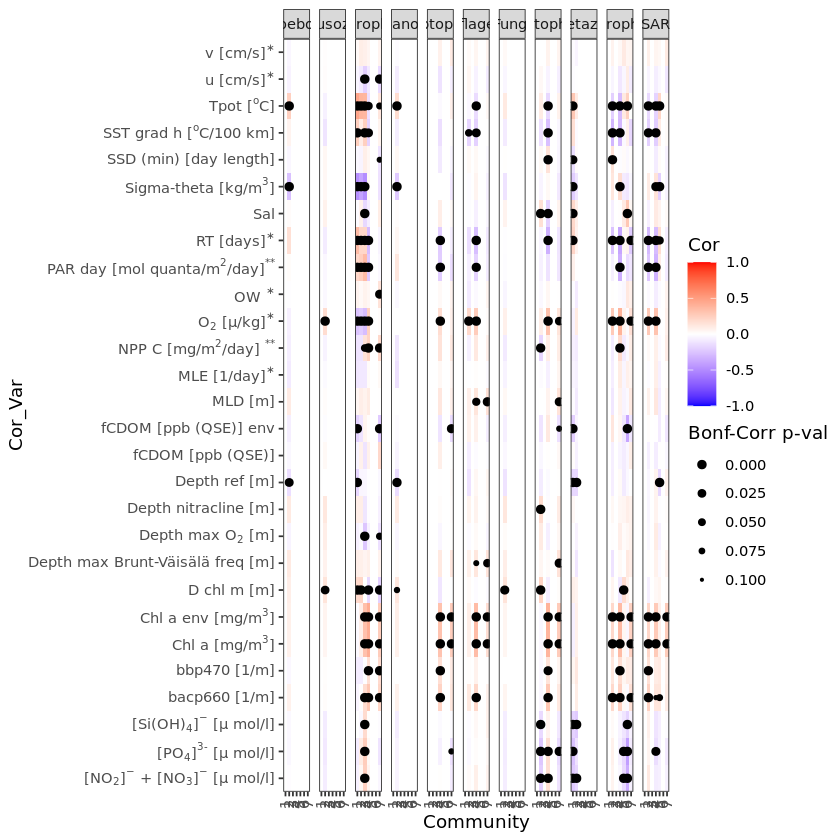

In [95]:
all_df = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m^2/day\\]^{**}",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\]^{*}",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\]^{*}",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m^2/day\\] ^{**}",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)_4\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO_4\\]^{3-} \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO_2\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO_2\\]^- + \\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/m^3\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW ^*",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m^3\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m^3\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\]^*",
                             Cor_Var == "O2" ~ 
                             "O_2 \\[$\\mu$/kg\\]^*",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[^oC\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O_2 \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\]^*",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[^oC/100 km\\]",
                         TRUE ~ Cor_Var))
pacman::p_load(latex2exp)
ggplot(all_df %>% dplyr::mutate(community = (as.character(community))) %>% 
        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
        dplyr::filter(Community != "NoCommunity")) + 
    geom_tile(aes(x=Community,y=Cor_Var,fill=Cor)) +
    geom_point(aes(x=Community,y=Cor_Var,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue") +
    #scale_size_area(limits = c(0,0.1), breaks = c(0,0.049,0.1),
    #                labels=c("HighSig","Significant","MarginallySig"),
    #                name = "Bonf-Corr p-val") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),name = "Bonf-Corr p-val") +
    facet_wrap(~groups,nrow=1) +
    theme_test() +
    scale_y_discrete(breaks = all_df$Cor_Var, 
        labels = parse(text=TeX(all_df$Cor_Var, output="character")),
        #parse(text=levels(dendro_env_labels$label)),
        expand = c(0, 0)) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave(file.path("..","si-figures","bygroup.png"),width=15,height=6,units="in",dpi=350)

**Community correlations based on only communities**

In [96]:
options(warn=-1)

all_df = data.frame()
for (var in vars_ofinterest) {
    current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM,na.rm=T)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM))) %>%
        group_by(community) %>% #groups
        dplyr::summarize(Cor=cor(!!as.symbol(var),TPM,use = "complete.obs",method="spearman"),
                         Cor_Pval=cor.test(!!as.symbol(var),TPM,method="spearman")$p.value) %>% 
        dplyr::mutate(community = (as.character(community))) %>%
        dplyr::mutate(Cor_Var = var)
    all_df = all_df %>% dplyr::bind_rows(current_df)
}
all_df$Cor_Pval = p.adjust(all_df$Cor_Pval, method = p.adjust.methods, n = length(all_df$Cor_Pval))
options(warn=0)

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You

In [97]:
all_df_test = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR - 8",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM Env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth (ref)",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chla Env",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Brunt-Väisälä depth",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Max O2 depth",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Nitracline depth",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ "SST",
                         TRUE ~ Cor_Var))

all_df = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m^2/day\\]^{**}",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\]^{*}",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\]^{*}",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m^2/day\\] ^{**}",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)_4\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO_4\\]^{3-} \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO_2\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO_2\\]^- + \\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\]^*",
                             Cor_Var == "O2" ~ 
                             "O_2 \\[$\\mu$/kg\\]^*",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/m^3\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW ^*",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m^3\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m^3\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[^oC\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O_2 \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\]^*",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[^oC/100 km\\]",
                         TRUE ~ Cor_Var))

corr_comm_only = ggplot(all_df %>% dplyr::mutate(community = (as.character(community))) %>% 
        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
        dplyr::filter(Community != "NoCommunity")) + 
    geom_tile(aes(x=Community,y=Cor_Var,fill=Cor)) +
    geom_point(aes(x=Community,y=Cor_Var,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue",name="Correlation") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),name = "Bonferroni\np-val") +
    theme_test() +
    ylab("") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [98]:
corr_df = all_df %>% pivot_wider(id_cols = community, names_from = Cor_Var, values_from = Cor) %>% 
    dplyr::filter(!is.na(community)) %>% column_to_rownames(var = "community")

In [99]:
community_station_data = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>%
        dplyr::filter(!is.na(community))

corr_df = community_station_data %>% dplyr::filter(!is.na(community)) %>%
    pivot_wider(id_cols = Station, names_from = community, values_from = TPM) %>% 
    column_to_rownames(var = "Station")

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.



In [100]:
cluster_dendro = as.dendrogram(hclust(dist(t(corr_df))))

In [101]:
environmental_station_data_byclust = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(TPM)) %>%
        group_by(Station) %>% #groups
        dplyr::summarize_if(is.numeric,mean,na.rm=TRUE) %>% 
        #dplyr::summarize_if(is.numeric,sum) %>% 
        dplyr::select(c(vars_ofinterest,"Station")) %>%
        pivot_longer(names_to = "Cor_Var",values_to="TPM",cols=-c("Station"))
environmental_station_data_byclust = environmental_station_data_byclust %>% 
                             dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR day \\[mol quanta/m^2/day\\]^{**}",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD \\[m\\]",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u \\[cm/s\\]^{*}",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v \\[cm/s\\]^{*}",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM \\[ppb (QSE)\\]",
                             Cor_Var == "NPP" ~ 
                             "NPP C \\[mg/m^2/day\\] ^{**}",
                             Cor_Var == "Nitrate" ~ 
                             "\\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Silica" ~ 
                             "\\[Si(OH)_4\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Phosphate" ~ 
                             "\\[PO_4\\]^{3-} \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrite" ~ 
                             "\\[NO_2\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "Nitrate+Nitrite" ~ 
                             "\\[NO_2\\]^- + \\[NO_3\\]^- \\[$\\mu$ mol/l\\]",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470 \\[1/m\\]",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660 \\[1/m\\]",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta \\[kg/m^3\\]",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM \\[ppb (QSE)\\] env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW ^*",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth ref \\[m\\]",
                             Cor_Var == "RT" ~ 
                             "RT \\[days\\]^*",
                             Cor_Var == "O2" ~ 
                             "O_2 \\[$\\mu$/kg\\]^*",
                             Cor_Var == "SSD" ~ 
                             "SSD (min) \\[day length\\]",
                             Cor_Var == "Chla" ~ 
                             "Chl a env \\[mg/m^3\\]",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chl a \\[mg/m^3\\]",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot \\[^oC\\]",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m \\[m\\]",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Depth max Brunt-Väisälä freq \\[m\\]",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Depth max O_2 \\[m\\]",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Depth nitracline \\[m\\]",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE \\[1/day\\]^*",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ 
                                                               "SST grad h \\[^oC/100 km\\]",
                         TRUE ~ Cor_Var)) %>%
                pivot_wider(id_cols = "Station", names_from = "Cor_Var", values_from = "TPM")
corr_df_env = environmental_station_data_byclust %>% column_to_rownames(var = "Station")

In [102]:
env_dendro = as.dendrogram(hclust(dist(t(corr_df_env))))

In [103]:
levels(dendro_env_labels$label)

[1] "bbp470 \\[1/m\\]"                              
 [2] "OW ^*"                                         
 [3] "MLE \\[1/day\\]^*"                             
 [4] "\\[PO_4\\]^{3-} \\[$\\mu$ mol/l\\]"            
 [5] "Chl a env \\[mg/m^3\\]"                        
 [6] "Chl a \\[mg/m^3\\]"                            
 [7] "bacp660 \\[1/m\\]"                             
 [8] "NPP C \\[mg/m^2/day\\] ^{**}"                  
 [9] "SSD (min) \\[day length\\]"                    
[10] "O_2 \\[$\\mu$/kg\\]^*"                         
[11] "Depth nitracline \\[m\\]"                      
[12] "\\[NO_2\\]^- + \\[NO_3\\]^- \\[$\\mu$ mol/l\\]"
[13] "\\[Si(OH)_4\\]^- \\[$\\mu$ mol/l\\]"           
[14] "fCDOM \\[ppb (QSE)\\] env"                     
[15] "fCDOM \\[ppb (QSE)\\]"                         
[16] "Depth ref \\[m\\]"                             
[17] "Sigma-theta \\[kg/m^3\\]"                      
[18] "Tpot \\[^oC\\]"                                
[19] "SST grad h \\[^oC/100 km\\]"                   
[20] "RT \\[days\\]^*"                               
[21] "Depth max O_2 \\[m\\]"                         
[22] "Sal"                                           
[23] "PAR day \\[mol quanta/m^2/day\\]^{**}"         
[24] "MLD \\[m\\]"                                   
[25] "D chl m \\[m\\]"                               
[26] "Depth max Brunt-Väisälä freq \\[m\\]"          
[27] "u \\[cm/s\\]^{*}"                              
[28] "v \\[cm/s\\]^{*}"

In [104]:
corr_df_env

,Depth ref \[m\],Sal,Tpot \[^oC\],Sigma-theta \[kg/m^3\],O_2 \[$\mu$/kg\]^*,\[PO_4\]^{3-} \[$\mu$ mol/l\],\[NO_2\]^- + \[NO_3\]^- \[$\mu$ mol/l\],\[Si(OH)_4\]^- \[$\mu$ mol/l\],Chl a env \[mg/m^3\],Chl a \[mg/m^3\],⋯,Depth max Brunt-Väisälä freq \[m\],Depth max O_2 \[m\],Depth nitracline \[m\],SSD (min) \[day length\],u \[cm/s\]^{*},v \[cm/s\]^{*},OW ^*,MLE \[1/day\]^*,SST grad h \[^oC/100 km\],RT \[days\]^*
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERR1700889,5.46967,36.286,27.2061,23.6206,192.9,0.230,0.0,1.440,0.09,0.02,⋯,82.875,29.000,115.143,724,4.221,11.550,0.332,0.029,27.788,27.00
ERR1700890,5.48592,36.025,29.0894,22.8043,187.4,0.140,0.1,1.470,0.02,0.00,⋯,56.750,30.000,75.333,735,-3.806,4.641,-0.157,0.030,29.293,29.24
ERR1700891,123.71229,36.172,24.9488,24.2513,193.0,0.020,0.1,1.170,0.16,0.05,⋯,151.111,243.667,270.750,638,7.302,-7.013,-3.490,0.062,NaN,NaN
ERR1700892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,728,NaN,NaN,NaN,NaN,NaN,NaN
ERR1700893,5.88710,36.238,25.0254,24.2701,193.9,0.010,0.1,1.260,0.12,0.03,⋯,132.714,29.143,354.857,628,-3.000,78.372,-1.571,0.378,NaN,NaN
ERR1700894,55.00000,37.823,16.1519,27.8877,NaN,0.020,0.1,0.600,0.43,0.43,⋯,34.500,NaN,NaN,714,-16.066,8.651,-0.774,0.083,24.398,24.74
ERR1700895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,697,NaN,NaN,NaN,NaN,NaN,NaN
ERR1700896,5.43325,38.378,21.4728,26.9370,197.6,0.010,0.0,0.540,0.05,0.01,⋯,70.000,80.000,NaN,627,-8.319,7.916,0.069,0.077,21.302,22.06
ERR1700897,183.31212,35.846,20.1716,25.3704,210.6,0.100,0.1,0.350,0.18,0.06,⋯,72.500,93.333,360.417,707,0.358,-1.710,-0.033,0.025,25.337,25.25


In [105]:
all_df_plot %>% dplyr::filter(community == 3)

community,Cor,Cor_Pval,Cor_Var,Community,Cor_Var_Ordered,Comm_Ordered
<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
3,-0.039233309,1.000000e+00,Depth ref \[m\],3,16,4
3,-0.163128517,1.069746e-04,Sal,3,22,4
3,0.380805562,1.835693e-31,Tpot \[^oC\],3,18,4
3,-0.498245188,8.733045e-57,Sigma-theta \[kg/m^3\],3,17,4
3,-0.293191502,2.718944e-17,O_2 \[$\mu$/kg\]^*,3,10,4
3,0.260325352,1.902947e-13,\[PO_4\]^{3-} \[$\mu$ mol/l\],3,4,4
3,0.246678762,5.950755e-12,\[NO_2\]^- + \[NO_3\]^- \[$\mu$ mol/l\],3,12,4
3,0.187878296,1.636699e-06,\[Si(OH)_4\]^- \[$\mu$ mol/l\],3,13,4
3,0.322653834,6.982460e-22,Chl a env \[mg/m^3\],3,5,4


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 129 rows containing missing values (geom_point).”
Warning message in as_grob.default(plot):
“Cannot convert object of class logical into a grob.”
Warning message:
“Removed 129 rows containing missing values (geom_point).”


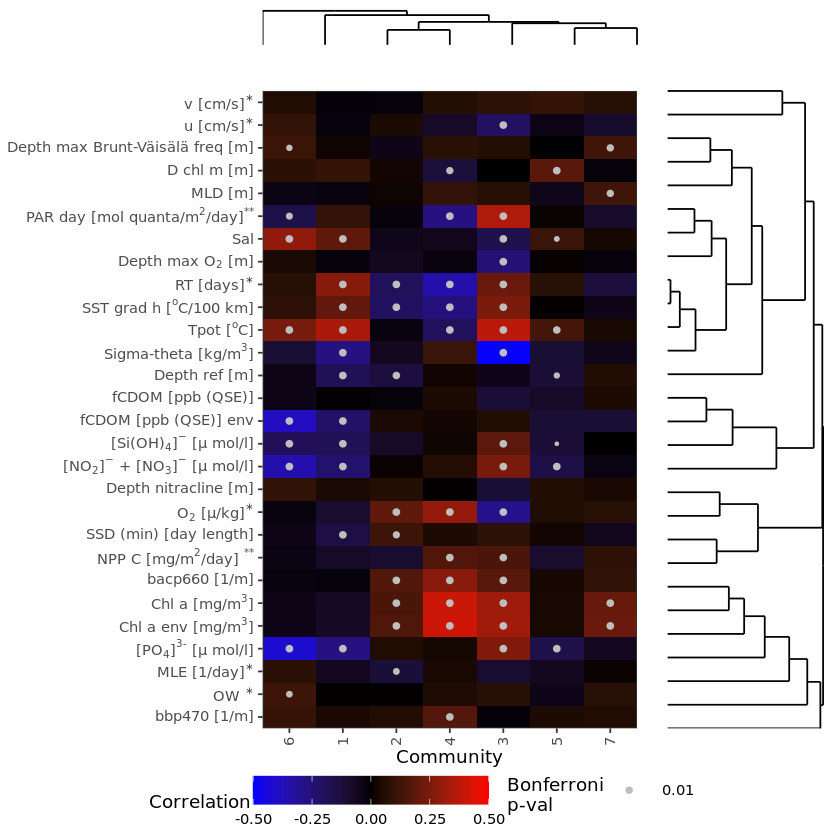

In [106]:
all_df_plot = all_df %>% dplyr::mutate(community = (as.character(community))) %>%
                        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
                        dplyr::filter(Community != "NoCommunity")

cluster_dendro = as.dendrogram(hclust(dist(t(corr_df),method="canberra")))
env_dendro = as.dendrogram(hclust(dist(t(corr_df_env),method="canberra")))
env.order <- order.dendrogram(env_dendro)

all_df_plot$Cor_Var_Ordered <- factor(x = all_df_plot$Cor_Var,
                               levels = colnames(corr_df_env)[env.order], 
                               ordered = TRUE)
all_df_plot$Cor_Var_Ordered <- match(all_df_plot$Cor_Var_Ordered,colnames(corr_df_env)[env.order])
comm.order <- order.dendrogram(cluster_dendro)

all_df_plot$Comm_Ordered <- factor(x = all_df_plot$community,
                               levels = colnames(corr_df)[comm.order], 
                               ordered = TRUE)
all_df_plot$Comm_Ordered <- match(all_df_plot$Comm_Ordered,colnames(corr_df)[comm.order])

dendro_env_labels = dendro_data(env_dendro, type = "rectangle")$labels
dendro_comm_labels = dendro_data(cluster_dendro, type = "rectangle")$labels
pacman::p_load(latex2exp)
corr_comm_only = ggplot(all_df_plot) + 
    geom_tile(aes(x=Comm_Ordered,y=Cor_Var_Ordered,fill=Cor)) +
    geom_point(aes(x=Comm_Ordered,y=Cor_Var_Ordered,size=Cor_Pval),color="gray") +
    scale_fill_gradient2(limits=c(-0.5,0.5),high = "red", mid = "black", low = "blue",name="Correlation ") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,1.5),breaks=c(0.01),name = "Bonferroni \np-val") +
    theme_test() +
    scale_y_continuous(breaks = dendro_env_labels$x, 
        labels = parse(text=TeX(levels(dendro_env_labels$label), output="character")),
        #parse(text=levels(dendro_env_labels$label)),
        expand = c(0, 0)) + 
    scale_x_continuous(breaks = dendro_comm_labels$x, 
        labels = dendro_comm_labels$label,
        expand = c(0, 0)) + 
    ylab("") + xlab("Community") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          legend.position = "bottom")
dendro_gg_env = ggplot(segment(dendro_data(env_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  coord_flip() +
  #scale_y_reverse(expand = c(0.2, 0)) + 
  scale_x_reverse(expand = c(0.2, 0)) + xlim(c(1,30)) + 
  theme_dendro()

dendro_gg_env = ggplot(segment(dendro_data(env_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  coord_flip() +
  scale_x_reverse(expand = c(0.2, 0)) + xlim(c(1,30)) + 
  scale_x_continuous(breaks = dendro_env_labels$x, 
                       labels = dendro_env_labels$label,
                       expand = c(0, 0)) + theme_dendro()

dendro_gg_comm = ggplot(segment(dendro_data(cluster_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  #scale_y_reverse(expand = c(0.2, 0)) + 
  theme_dendro()

dendro_gg_comm_labels = dendro_data(cluster_dendro, type = "rectangle")$labels
dendro_gg_comm = ggplot(segment(dendro_data(cluster_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) +
  scale_x_continuous(breaks = dendro_gg_comm_labels$x, 
                       labels = dendro_gg_comm_labels$label,
                       expand = c(0, 0)) + theme_dendro()

corr_comm_only_dendro = cowplot::plot_grid(dendro_gg_comm,
                                           corr_comm_only + theme(plot.margin=grid::unit(c(-10,-5,-3,-3), "mm"),
                                                                  legend.position="none"), 
                                           rel_heights=c(0.12,1),rel_widths=c(0.3,1,0.3,1),
                                           ncol=1, align="hv",axis = "tblr")
#t, r, b, l  (trouble, top-right-bottom-left)
corr_comm_only_alldendro = cowplot::plot_grid(corr_comm_only_dendro + 
                                              theme(plot.margin=grid::unit(c(0,0,0,0), "mm")),
                                              cowplot::plot_grid(NA,dendro_gg_env,
                                                                 rel_heights=c(0.12,1),ncol=1), #+ 
                                              #theme(plot.margin=grid::unit(c(-8,0,-25,-10), "mm")), 
                   rel_widths=c(1,0.3),ncol=2,align = "v", axis = "tb")
corr_comm_only_alldendro = cowplot::plot_grid(corr_comm_only_alldendro,
                                              get_legend(corr_comm_only+
                                                         theme(legend.key.width=unit(1,"cm"))),
                                              ncol=1,rel_heights=c(1,0.1))
corr_comm_only_alldendro

In [174]:
all_df_plot %>% dplyr::filter(community == 4)

community,Cor,Cor_Pval,Cor_Var,Community,Cor_Var_Ordered,Comm_Ordered
<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
4,0.020386885,1.000000e+00,Depth ref \[m\],4,16,4
4,-0.049349953,1.000000e+00,Sal,4,22,4
4,-0.194805480,3.212329e-07,Tpot \[^oC\],4,18,4
4,0.110176982,1.135843e-01,Sigma-theta \[kg/m^3\],4,17,4
4,0.300220112,3.332426e-18,O_2 \[$\mu$/kg\]^*,4,10,4
4,0.026046026,1.000000e+00,\[PO_4\]^{3-} \[$\mu$ mol/l\],4,4,4
4,0.059016795,1.000000e+00,\[NO_2\]^- + \[NO_3\]^- \[$\mu$ mol/l\],4,12,4
4,0.014609391,1.000000e+00,\[Si(OH)_4\]^- \[$\mu$ mol/l\],4,13,4
4,0.409283491,6.379988e-37,Chl a env \[mg/m^3\],4,5,4


Now we'll calculate some graph metrics, in particular:
* Average correlation coefficient within-community
* number of >0.70 correlations between each community (measure of community similarity)
* within-community degree.

In [ ]:
pacman::p_load(ggforce,ggnewscale)

In [123]:
read.csv("/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/rename/renamed-eukaryotic-mags.tsv",sep="\t")

old_mag_name,new_mag_name
<fct>,<fct>
IO-all-DCM-0-8-5-00_bin-104,TOPAZ_IOD1_E001
IO-all-DCM-0-8-5-00_bin-107,TOPAZ_IOD1_E002
IO-all-DCM-0-8-5-00_bin-111,TOPAZ_IOD1_E003
IO-all-DCM-0-8-5-00_bin-12,TOPAZ_IOD1_E004
IO-all-DCM-0-8-5-00_bin-120,TOPAZ_IOD1_E005
IO-all-DCM-0-8-5-00_bin-130,TOPAZ_IOD1_E006
IO-all-DCM-0-8-5-00_bin-147,TOPAZ_IOD1_E007
IO-all-DCM-0-8-5-00_bin-157,TOPAZ_IOD1_E008
IO-all-DCM-0-8-5-00_bin-17,TOPAZ_IOD1_E009


In [129]:
renamed_mags = read.csv("/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/rename/renamed-eukaryotic-mags.tsv",sep="\t")

layout_gr_broadclasses = layout_gr_classes %>%
    dplyr::left_join(cluster_groups, by = c("mag"="Cluster")) %>%
    dplyr::mutate(MAG = case_when((MAG != "") & !(is.na(MAG)) ~ MAG,
                                  TRUE ~ mag)) %>%
    dplyr::left_join(renamed_mags,by = c("MAG" = "old_mag_name")) %>%
    dplyr::mutate(groups_full = paste(Domain,Clade,Kingdom,Supergroup,Phylum,Class,sep=";")) %>%
    dplyr::mutate(groups = case_when(Kingdom == "Fungi" ~ "Fungi",
                                     grepl("Metazoa",groups_full) ~ "Metazoa",
                                     grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                     grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                     grepl("Cryptophyceae",groups_full) ~ "Cryptophyta",
                                     grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                     grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                     (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                     (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                     (groups_full == "Stramenopiles;-") ~ "Sar",
                                     (groups_full == "Stramenopiles;") ~ "Sar",
                                      grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                      grepl("Apusozoa",groups_full)  ~ "Apusozoa",
                                     ((Kingdom == ".") & (Clade == "Sar") & 
                                     (Phylum == ".") & (Class == ".")) ~ "Sar",
                                     (groups_full == "-;") ~ "Eukaryota",
                                     (groups_full == "-;-") ~ "Eukaryota",
                                     (groups_full == ";-") ~ "Eukaryota",
                                     (Clade == "Sar") ~ "Sar",
                                     TRUE ~ "Bacteria"))%>%
                      dplyr::mutate(groups = as.character(groups)) %>%
                      dplyr::left_join(harriet_groups,by = c("new_mag_name"="X")) %>%
                      dplyr::mutate(harriet_groups = as.character(harriet_groups)) %>%
                      dplyr::mutate(groups = case_when((harriet_groups != "") & !is.na(harriet_groups) ~ harriet_groups,
                                                       TRUE ~ groups))

color_groups = read.csv('/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/data/taxonomy_color_ranges.csv', 
                   row.names=1) %>% dplyr::mutate(mags = rownames(.)) %>%
                    dplyr::left_join(renamed_mags,
                     by = c("mags" = "old_mag_name")) %>%
                   dplyr::rename("groups_full" = "name") %>%
                   dplyr::mutate(groups = case_when(grepl("Fungi",groups_full) ~ "Fungi",
                                     grepl("Metazoa",groups_full) ~ "Metazoa",
                                     grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                     grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                     grepl("Cryptophyceae",groups_full) ~ "Cryptophyta",
                                     grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                     grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                     (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                     (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                     (groups_full == "Stramenopiles;-") ~ "Sar",
                                     (groups_full == "Stramenopiles;") ~ "Sar",
                                      grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                      grepl("Apusozoa",groups_full)  ~ "Apusozoa",
                                     (grepl("SAR",groups_full) | 
                                      grepl("Stramenopiles",groups_full) | 
                                      grepl("Alveolata",groups_full)) ~ "Sar",
                                     (groups_full == "-;") ~ "Eukaryota",
                                     (groups_full == "-;-") ~ "Eukaryota",
                                     (groups_full == ";-") ~ "Eukaryota",
                                     grepl("Eukaryota",groups_full) ~ "Eukaryota",
                                     TRUE ~ "Bacteria"))%>%
                      dplyr::mutate(groups = as.character(groups)) %>%
                      dplyr::left_join(harriet_groups,by = c("new_mag_name"="X")) %>%
                      dplyr::mutate(harriet_groups = as.character(harriet_groups)) %>%
                      dplyr::mutate(groups = case_when((harriet_groups != "") & !is.na(harriet_groups) ~ harriet_groups,
                                                       TRUE ~ groups))

In [130]:
distinct_cols <- c("#4b9200","#98008d","#93d779","black","#ff55b0","#2a5e2b",
                   "#e195ff","#fb9113","#01acc8","#f12450","#7d6100",
                   "#793e69","#a54d00","#f2bb95")
community_cols = data.frame("community" = c(1:7), "commcolors" = distinct_cols[8:14])
layout_gr_broadclasses = layout_gr_broadclasses %>% 
    dplyr::left_join(color_groups %>% dplyr::select(color,groups), by = "groups") %>%
    dplyr::mutate(color = as.character(color)) %>%
    dplyr::mutate(community = as.numeric(community)) %>%
    dplyr::left_join(community_cols) %>%
    dplyr::mutate(commcolors = as.character(commcolors)) %>%
    dplyr::mutate(color = case_when((groups == "Bacteria") ~ "white",#commcolors,#"white",
                                    #(groups == "Amoebozoa") ~ "yellow",
                                    #(groups == "Apusozoa") ~ "#daa520",
                                    (groups == "Amoebozoa") ~ '#E66B92',
                                    (groups == "Choanozoa") ~ '#FCDCFF',
                                    (groups == "Dinoflagellata") ~ '#18AB7B',
                                    (groups == "Apusozoa") ~ '#9A6ACD',
                                    (groups == "Cryptophyta") ~ '#C6BE53',
                                    TRUE ~ color)) %>%
    dplyr::distinct()

Joining, by = "community"



In [131]:
(layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$color

[1] "#481358" "#2F0D3B" "#61186D" "#FCDCFF" "#481358" "#2F0D3B" "#61186D"
   [8] "#481358" "#2F0D3B" "#61186D" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919"
  [15] "#7DB61B" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D"
  [22] "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#FCDCFF"
  [29] "#EB9E7A" "#CDCBCC" "#1D8C8A" "#1EAEA0" "#31C4AB" "#19A39A" "#ACDCC8"
  [36] "#EB9E7A" "#CDCBCC" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
  [43] "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D"
  [50] "#EB9E7A" "#CDCBCC" "#EB9E7A" "#CDCBCC" "#481358" "#2F0D3B" "#61186D"
  [57] "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358"
  [64] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
  [71] "#61186D" "#481358" "#2F0D3B" "#61186D" "#EB9E7A" "#CDCBCC" "#481358"
  [78] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#DFF2A6" "#D4EC83"
  [85] "#A2D520" "#95A919" "#7DB61B" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919"
  [92] "#7DB61B" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#481358"
  [99] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [106] "#61186D" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#481358"
 [113] "#2F0D3B" "#61186D" "#EB9E7A" "#CDCBCC" "#EB9E7A" "#CDCBCC" "#481358"
 [120] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [127] "#61186D" "#1D8C8A" "#1EAEA0" "#31C4AB" "#19A39A" "#ACDCC8" "#481358"
 [134] "#2F0D3B" "#61186D" "#18AB7B" "#481358" "#2F0D3B" "#61186D" "#481358"
 [141] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [148] "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D"
 [155] "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358"
 [162] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [169] "#61186D" "#481358" "#2F0D3B" "#61186D" "#6EAA93" "#28867E" "#481358"
 [176] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [183] "#61186D" "#1D8C8A" "#1EAEA0" "#31C4AB" "#19A39A" "#ACDCC8" "#6EAA93"
 [190] "#28867E" "#481358" "#2F0D3B" "#61186D" "#DFF2A6" "#D4EC83" "#A2D520"
 [197] "#95A919" "#7DB61B" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [204] "#61186D" "#481358" "#2F0D3B" "#61186D" "#6EAA93" "#28867E" "#481358"
 [211] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#18AB7B" "#481358"
 [218] "#2F0D3B" "#61186D" "#6EAA93" "#28867E" "#EB9E7A" "#CDCBCC" "#DFF2A6"
 [225] "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#18AB7B" "#18AB7B" "#18AB7B"
 [232] "#481358" "#2F0D3B" "#61186D" "#1D8C8A" "#1EAEA0" "#31C4AB" "#19A39A"
 [239] "#ACDCC8" "#C6BE53" "#C6BE53" "#1D8C8A" "#1EAEA0" "#31C4AB" "#19A39A"
 [246] "#ACDCC8" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#DFF2A6"
 [253] "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#6EAA93" "#28867E" "#C6BE53"
 [260] "#C6BE53" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#EB9E7A"
 [267] "#CDCBCC" "#481358" "#2F0D3B" "#61186D" "#E66B92" "#C6BE53" "#481358"
 [274] "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [281] "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D"
 [288] "#6EAA93" "#28867E" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B"
 [295] "#61186D" "#6EAA93" "#28867E" "#6EAA93" "#28867E" "#1D8C8A" "#1EAEA0"
 [302] "#31C4AB" "#19A39A" "#ACDCC8" "#6EAA93" "#28867E" "#481358" "#2F0D3B"
 [309] "#61186D" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#E66B92"
 [316] "#E66B92" "#481358" "#2F0D3B" "#61186D" "#DFF2A6" "#D4EC83" "#A2D520"
 [323] "#95A919" "#7DB61B" "#EB9E7A" "#CDCBCC" "#481358" "#2F0D3B" "#61186D"
 [330] "#1D8C8A" "#1EAEA0" "#31C4AB" "#19A39A" "#ACDCC8" "#481358" "#2F0D3B"
 [337] "#61186D" "#481358" "#2F0D3B" "#61186D" "#481358" "#2F0D3B" "#61186D"
 [344] "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#DFF2A6" "#D4EC83"
 [351] "#A2D520" "#95A919" "#7DB61B" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919"
 [358] "#7DB61B" "#DFF2A6" "#D4EC83" "#A2D520" "#95A919" "#7DB61B" "#DFF2A6"

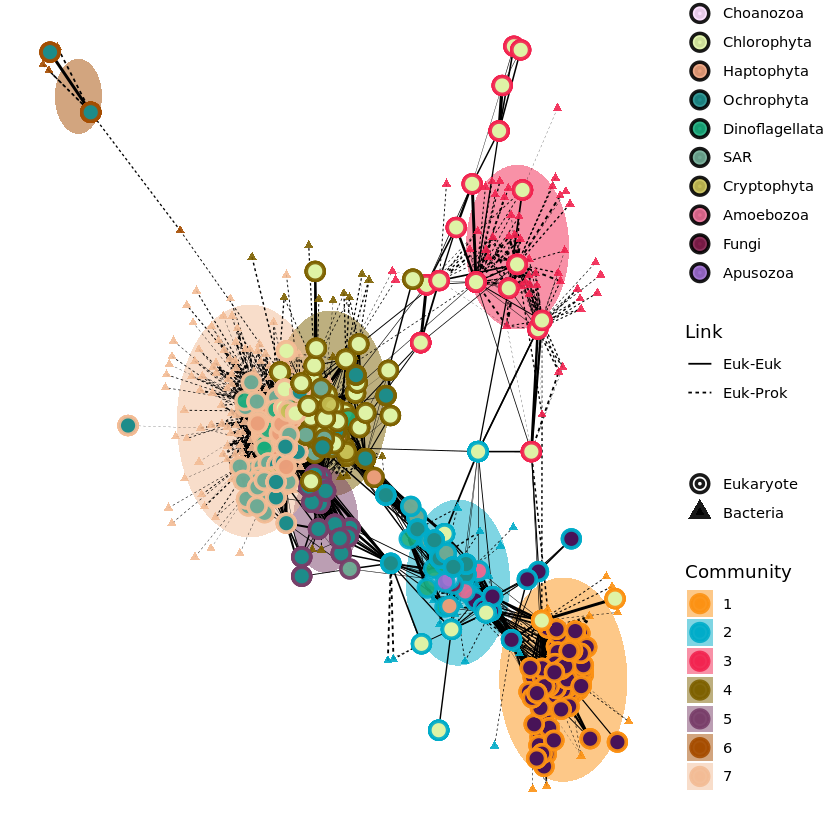

In [132]:
cluster_centers = layout_gr %>% dplyr::group_by(community) %>% 
                    dplyr::summarize(mean_x = mean(V1),mean_y=mean(V2),n_points=n())
distinct_cols <- c("#6068da","#50c150","#8f45b4","#acb833","#c273e5",
                   "#81b84c","#c84aa9","#428529","#e64586","#5cc799",
                   "#b53b6d","#5eae6c","#cc454d","#41bcb8","#d2522c",
                   "#48a8d7","#da9c31","#4a68b5","#96872b","#a792df",
                   "#686d2b","#88589b","#b1b268","#6e94d7","#9d5e2e",
                   "#d987c3","#377c53","#e18088","#dd9662","#9b4d68")
distinct_cols <- c("#4b9200","#98008d","#93d779","black","#ff55b0","#2a5e2b",
                   "#e195ff","#fb9113","#01acc8","#f12450","#7d6100",
                   "#793e69","#a54d00","#f2bb95")
network_plot = ggplot() +
    ggforce::geom_circle(data = cluster_centers, aes(x0 = mean_x, y0 = mean_y, r = (n_points)^(1/3),
                                                     fill = factor(community)), col = NA, alpha = 0.5) + 
    scale_fill_manual(name = "Community", values = distinct_cols[8:14]) + 
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
    new_scale_fill() + 
    geom_point(data=layout_gr_broadclasses %>% dplyr::filter(Domain != "Eukaryota"), #%>% 
               #dplyr::mutate(groups = case_when((is.na(Supergroup)) | (Supergroup == "NA") ~ "Bacteria",
               #                                     TRUE ~ Supergroup)),
               aes(x=V1,y=V2,shape=factor(eukprok),fill=factor(groups),color=factor(community)),
               alpha=0.9,stroke=1.5,size=1) +
    geom_point(data=layout_gr_broadclasses %>% dplyr::filter(Domain == "Eukaryota"),
               aes(x=V1,y=V2,shape=factor(eukprok),fill=factor(groups),color=factor(community)),
               alpha=0.9,stroke=1.5,size=4) +
    scale_fill_manual(name = "Taxonomic\nGroup", 
                      breaks = (layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$groups, 
                      values = (layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$color) + #values = distinct_cols[1:7]) + 
    scale_color_manual(name = "Community", values = distinct_cols[8:14]) + 
    guides(fill = guide_legend(override.aes = list("shape"=21))) + 
    theme_bw() +
    scale_shape_manual(name = "", values=c(21,17), breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
    scale_size(range = c(0, 1),labels=c("0.7","0.8","0.9"),breaks=c(0.7,0.8,0.9),name="") + 
    theme(
      axis.text.x = element_blank(),  # remove x-axis text
      axis.text.y = element_blank(), # remove y-axis text
      axis.ticks = element_blank(),  # remove axis ticks
      axis.title.x = element_blank(), # remove x-axis labels
      axis.title.y = element_blank(), # remove y-axis labels
      panel.background = element_blank(), 
      panel.border =element_blank(), 
      panel.grid.major = element_blank(),  #remove major-grid labels
      panel.grid.minor = element_blank(),  #remove minor-grid labels
      plot.background = element_blank())
network_plot
ggsave("network_plot.png",width=12,height=8,units="in")

In [133]:
reclustered_network_posneg = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt_all$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt_all$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(abs(corrcoef) > 0.7) %>%
    dplyr::filter(from != to) 
reclustered_network_posneg$Domain_to[is.na(reclustered_network_posneg$Domain_to)] = "Bacteria"
reclustered_network_posneg$Domain_from[is.na(reclustered_network_posneg$Domain_from)] = "Bacteria"

In [134]:
tracking_communities = reclustered_network_posneg %>% dplyr::left_join(layout_gr_broadclasses %>% #dplyr::select(mag,community,classification) %>%
                             dplyr::rename(c("community_to" = "community",
                                             "Domain_to" = "Domain",
                                             "Supergroup_to" = "Supergroup",
                                             "Group_to" = "groups",
                                             "Phylum_to" = "Phylum",
                                             "degree_to" = "degree")), by = c("to" = "mag")) %>%
            dplyr::left_join(layout_gr_broadclasses %>% #dplyr::select(mag,community,classification) %>%
                             dplyr::rename(c("community_from" = "community",
                                             "Domain_from" = "Domain",
                                             "Supergroup_from" = "Supergroup",
                                             "Group_from" = "groups",
                                             "Phylum_from" = "Phylum",
                                             "degree_from" = "degree")), by = c("from" = "mag")) %>%
            dplyr::distinct(.keep_all=TRUE)

In [39]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

head(tracking_communities)

,X,to,from,corrcoef,Link,Dom1,Dom2,Completeness.x,Contamination.x,Completeness.y,Contamination.y,Domain_from.x,Clade_from,Kingdom_from,Supergroup_from.x,Phylum_from.x,Class_from,Order_from,Family_from,Genus_from,Species_from,Domain_to.x,Clade_to,Kingdom_to,Supergroup_to.x,Phylum_to.x,Class_to,Order_to,Family_to,Genus_to,Species_to,Cluster_From,classification.x,Cluster_To,classification.y,V1.x,V2.x,eukprok.x,Domain_to.y,Clade.x,Kingdom.x,Supergroup_to.y,Phylum_to.y,Class.x,Order.x,Family.x,Genus.x,Species.x,community_to,degree_to,groups_full.x,Group_to,color.x,commcolors.x,V1.y,V2.y,eukprok.y,Domain_from.y,Clade.y,Kingdom.y,Supergroup_from.y,Phylum_from.y,Class.y,Order.y,Family.y,Genus.y,Species.y,community_from,degree_from,groups_full.y,Group_from,color.y,commcolors.y
,<int>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,9,Cluster_3,Cluster_1,0.7061998,Euk-Euk,euk,euk,57.64706,1.176471,62.7451,0.3921569,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,Cluster_1,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,Cluster_3,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Harpacticoida;Harpacticidae;Tigriopus;Tigriopus californicus,12.75047,-6.619327,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,1,37,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#481358,#fb9113,12.90524,-5.424501,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,1,29,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#481358,#fb9113
2,9,Cluster_3,Cluster_1,0.7061998,Euk-Euk,euk,euk,57.64706,1.176471,62.7451,0.3921569,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,Cluster_1,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,Cluster_3,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Harpacticoida;Harpacticidae;Tigriopus;Tigriopus californicus,12.75047,-6.619327,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,1,37,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#481358,#fb9113,12.90524,-5.424501,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,1,29,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#2F0D3B,#fb9113
3,9,Cluster_3,Cluster_1,0.7061998,Euk-Euk,euk,euk,57.64706,1.176471,62.7451,0.3921569,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,Cluster_1,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,Cluster_3,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Harpacticoida;Harpacticidae;Tigriopus;Tigriopus californicus,12.75047,-6.619327,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigri

In [135]:
total_communities = layout_gr_broadclasses %>% dplyr::distinct(mag,.keep_all=TRUE) %>% 
    dplyr::group_by(community) %>% dplyr::tally()

In [149]:
total_communities_supergroup = layout_gr_broadclasses %>% dplyr::distinct(mag,.keep_all=TRUE) %>% 
    dplyr::group_by(community,groups,color) %>% 
    dplyr::mutate(groups = case_when(groups == "NA" ~ "Bacteria",
                                         TRUE ~ groups)) %>% dplyr::tally()

In [137]:
total_communities_supergroup

community,groups,color,n
<dbl>,<chr>,<chr>,<int>
1,Bacteria,white,14
1,Chlorophyta,#DFF2A6,2
1,Metazoa,#481358,105
2,Amoebozoa,#E66B92,3
2,Apusozoa,#9A6ACD,1
2,Bacteria,white,20
2,Chlorophyta,#DFF2A6,6
2,Choanozoa,#FCDCFF,3
2,Dinoflagellata,#18AB7B,5


In [138]:
distinct_cols = total_communities_supergroup %>% dplyr::ungroup() %>% dplyr::distinct(groups,color)
distinct_cols

groups,color
<chr>,<chr>
Bacteria,white
Chlorophyta,#DFF2A6
Metazoa,#481358
Amoebozoa,#E66B92
Apusozoa,#9A6ACD
Choanozoa,#FCDCFF
Dinoflagellata,#18AB7B
Fungi,#821C4A
Haptophyta,#EB9E7A


In [148]:
unique((total_communities_supergroup %>% dplyr::filter(community== 2))$groups)
total_communities_supergroup

[1] Amoebozoa      Apusozoa       Bacteria       Chlorophyta    <NA>          
 [6] Dinoflagellata Fungi          Haptophyta     Metazoa        Ochrophyta    
[11] SAR           
11 Levels: Bacteria < Amoebozoa < Apusozoa < Chlorophyta < ... < Metazoa

community,groups,color,n
<dbl>,<ord>,<chr>,<int>
1,Bacteria,white,14
1,Chlorophyta,#DFF2A6,2
1,Metazoa,#481358,105
2,Amoebozoa,#E66B92,3
2,Apusozoa,#9A6ACD,1
2,Bacteria,white,20
2,Chlorophyta,#DFF2A6,6
2,NA,#FCDCFF,3
2,Dinoflagellata,#18AB7B,5


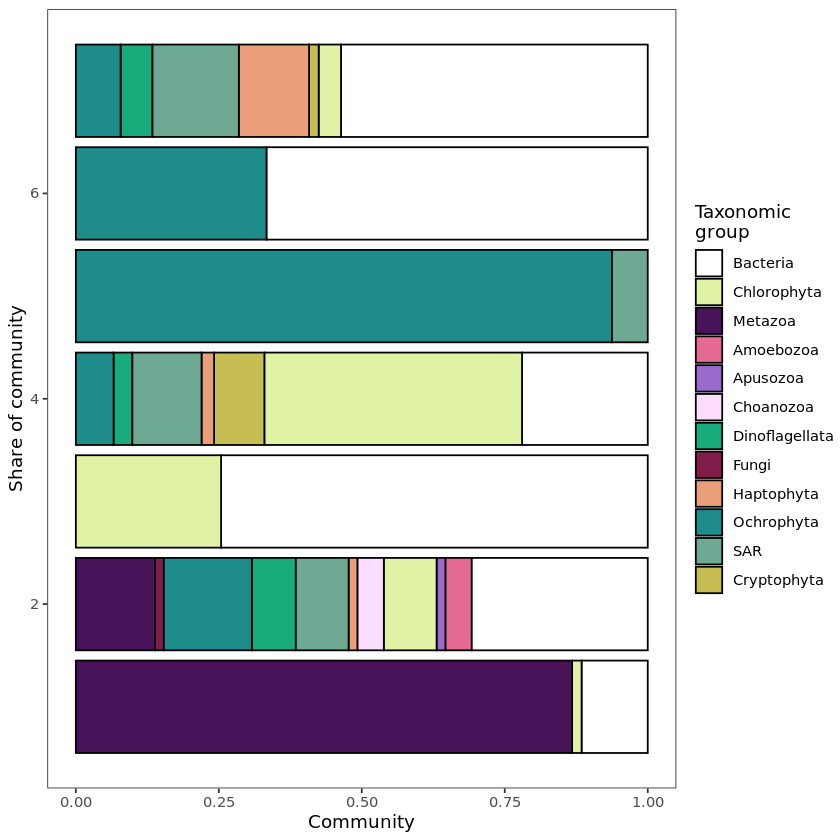

In [150]:
total_communities_supergroup$groups = ordered(total_communities_supergroup$groups,
                                       levels=c("Bacteria","Amoebozoa","Apusozoa","Chlorophyta","Choanozoa",
                                                       "Cryptophyta","Haptophyta","SAR","Dinoflagellata",
                                                       "Ochrophyta","Fungi","Metazoa"))
total_comm_bar = ggplot(total_communities_supergroup) + geom_bar(aes(x = community, y = n, 
                                                                     fill = groups),
                                            position = "fill", stat = "identity",color="black") + coord_flip() + 
    theme_test() + ylab("Community") + xlab("Share of community") + 
    scale_fill_manual(name = "Taxonomic\ngroup", breaks = distinct_cols$groups,
                      values = distinct_cols$color)
total_comm_bar

In [151]:
# We want to divide the number of connections actually observed between each community to 
# the total possible between two communities, which is the size of the two communities
# multiplied together.
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}
tracking_communities = tracking_communities %>% 
    dplyr::arrange(desc(corrcoef)) %>%
    dplyr::distinct(to,from,.keep_all=TRUE) %>%
    dplyr::filter(Link != "Other")
tracking_communities$comboclust = get_combo(tracking_communities)
tracking_communities = tracking_communities %>% 
    dplyr::arrange(desc(corrcoef)) %>%
    dplyr::distinct(comboclust,.keep_all=TRUE)
summarized_connections = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::summarize(corrcoefmean = mean(corrcoef),number_connections=n()) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_to"="n"),by = c("community_to"="community")) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_from"="n"),by = c("community_from"="community")) %>%
    dplyr::mutate(possible_between = size_to * size_from)

`summarise()` has grouped output by 'community_to'. You can override using the `.groups` argument.



In [152]:
# Make a dataframe for each "from" link documenting the number of communities
# it is linked to
df1 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(from,community_to,.keep_all=T) %>%
    dplyr::rename("candidate"="from")

# Make a dataframe for each "to" link documenting the number of communities
# it is linked to
df2 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(to,community_from,.keep_all=T) %>%
    dplyr::rename("candidate"="to")

# combine the two DataFrames to account for each community member's level of
# inter-community engagement without duplications
tester = df1 %>% dplyr::bind_rows(df2) %>% 
    dplyr::distinct(candidate,community_to,community_from,.keep_all=T) %>% 
    dplyr::group_by(community_to,community_from) %>% 
    # tally up the total number of other communities each candidate engages with.
    dplyr::tally()

In [178]:
total_communities = layout_gr_classes %>% 
    dplyr::group_by(community) %>% dplyr::tally() %>%
    dplyr::mutate(community = as.integer(community))

df1 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(from,community_to,.keep_all=T) %>%
    dplyr::rename("candidate"="from")

df2 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(to,community_from,.keep_all=T) %>%
    dplyr::rename("candidate"="to")
tester = df1 %>% dplyr::bind_rows(df2) %>% 
    dplyr::distinct(candidate,community_to,community_from,.keep_all=T) %>% 
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::tally() %>%
    dplyr::rename("number_connections" = "n")

summarized_connections = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::summarize(corrcoefmean = mean(corrcoef),dense_connections=n()) %>%
    dplyr::left_join(tester,by=c("community_to","community_from")) %>%
    dplyr::mutate(number_connections = case_when(community_to==community_from ~ dense_connections,
                                                 TRUE ~ number_connections)) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_to"="n"),by = c("community_to"="community")) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_from"="n"),by = c("community_from"="community")) %>%
    dplyr::mutate(possible_between = max(size_to,size_from)) %>%# * size_from) %>%
    dplyr::mutate(possible_between = case_when(community_to==community_from ~ 
                                               as.integer((as.integer(size_to) * (as.integer(size_to) - 1)) / 2),
                                               #as.integer(lapply(lapply(size_to,as.integer),choose,2)),
                                               TRUE ~ possible_between))

`summarise()` has grouped output by 'community_to'. You can override using the `.groups` argument.



In [179]:
tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from)

X,to,from,corrcoef,Link,Dom1,Dom2,Completeness.x,Contamination.x,Completeness.y,⋯,degree_from,MAG.y,classification.y.y,new_mag_name.y,groups_full.y,Group_from,harriet_groups.y,color.y,commcolors.y,comboclust
<int>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6386131,Cluster_295,Cluster_198,0.9923414,Euk-Euk,euk,euk,30.98039,0.0000000,30.98039,⋯,67,SPO-all-SRF-180-2000-00_bin-318,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,TOPAZ_SPS4_E052,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,Metazoa,#481358,#fb9113,Cluster_198_Cluster_295
1475813,Cluster_82,Cluster_60,0.9920738,Euk-Euk,euk,euk,32.94118,0.3921569,36.07843,⋯,25,SPO-SPSG-SRF-0-8-5-00_bin-565,Eukaryota;Opisthokonta;Metazoa;Metazoa;-;Choanoflagellata;Craspedida;Salpingoecidae;Salpingoeca;Salpingoeca rosetta,TOPAZ_SPS1_E029,Eukaryota;Opisthokonta;Metazoa;Metazoa;-;Choanoflagellata,Choanozoa,Choanozoa,#FCDCFF,#01acc8,Cluster_60_Cluster_82
697312,RS-all-SRF-180-2000-00_bin-6,RS-all-SRF-20-180-00_bin-6,0.9917608,Prok-Prok,prok,prok,NA,NA,NA,⋯,1,RS-all-SRF-20-180-00_bin-6,NA,NA,d__Bacteria;NA;NA;NA;p__Cyanobacteria;c__Cyanobacteriia,Bacteria,NA,white,#a54d00,RS-all-SRF-180-2000-00_bin-6_RS-all-SRF-20-180-00_bin-6
7681510,Cluster_334,Cluster_241,0.9901239,Euk-Euk,euk,euk,73.72549,1.9607843,60.00000,⋯,67,NPO-all-SRF-180-2000-00_bin-18,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,TOPAZ_NPS4_E003,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,Metazoa,#481358,#fb9113,Cluster_241_Cluster_334
4083643,Cluster_164,Cluster_143,0.9875573,Euk-Euk,euk,euk,55.68627,0.3921569,40.39216,⋯,37,SPO-SPSG-SRF-20-180-00_bin-113,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,TOPAZ_SPS3_E018,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,Metazoa,#481358,#fb9113,Cluster_143_Cluster_164
4153218,Cluster_322,Cluster_147,0.9866529,Euk-Euk,euk,euk,49.01961,0.3921569,47.84314,⋯,3,IO-all-SRF-0-8-5-00_bin-341,Eukaryota;core chlorophytes;Viridiplantae;Archaeplastida;Chlorophyta;-;-;-;.;-,TOPAZ_IOS1_E029,Eukaryota;core chlorophytes;Viridiplantae;Archaeplastida;Chlorophyta;-,Chlorophyta,Chlorophyta,#DFF2A6,#f12450,Cluster_147_Cluster_322
697709,SPO-SPSG-MIX-0-8-5-00_bin-231,RS-all-SRF-20-180-00_bin-6,0.9856379,Prok-Prok,prok,prok,NA,NA,NA,⋯,1,RS-all-SRF-20-180-00_bin-6,NA,NA,d__Bacteria;NA;NA;NA;p__Cyanobacteria;c__Cyanobacteriia,Bacteria,NA,white,#a54d00,RS-all-SRF-20-180-00_bin-6_SPO-SPSG-MIX-0-8-5-00_bin-231
5376311,SPO-PEOD-DCM-0-8-5-00_bin-52,NPO-all-DCM-0-8-5-00_bin-28,0.9852933,Prok-Prok,prok,prok,NA,NA,NA,⋯,2,NPO-all-DCM-0-8-5-00_bin-28,NA,NA,d__Bacteria;NA;NA;NA;p__Planctomycetota;c__Phycisphaerae,Bacteria,NA,white,#f12450,NPO-all-DCM-0-8-5-00_bin-28_SPO-PEOD-DCM-0-8-5-00_bin-52
7534563,SPO-SPSG-SRF-20-180-00_bin-189,SPO-all-SRF-5-20-00_bin-155,0.9845218,Prok-Prok,prok,prok,NA,NA,NA,⋯,1,SPO-all-SRF-5-20-00_bin-155,NA,NA,d__Bacteria;NA;NA;NA;p__Verrucomicrobiota;c__Verrucomicrobiae,Bacteria,NA,white,#f12450,SPO-all-SRF-5-20-00_bin-155_SPO-SPSG-SRF-20-180-00_bin-189


In [181]:
summarized_connections %>% dplyr::mutate(Connectedness = number_connections/possible_between) %>%
    dplyr::filter(community_to == community_from) #%>% dplyr::ungroup() %>%
    #dplyr::summarize(meanconnex = mean(Connectedness),sdconnex = sd(Connectedness,na.rm=T))

community_to,community_from,corrcoefmean,dense_connections,number_connections,size_to,size_from,possible_between,Connectedness
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,0.7806431,2589,2589,121,121,7260,0.3566116
2,2,0.7649711,475,475,65,65,2080,0.2283654
3,3,0.7672979,548,548,63,63,1953,0.2805940
4,4,0.7609866,912,912,91,91,4095,0.2227106
5,5,0.7810378,66,66,16,16,120,0.5500000
6,6,0.8395734,11,11,6,6,15,0.7333333
7,7,0.7639936,2888,2888,179,179,15931,0.1812818


In [156]:
tester

community_to,community_from,number_connections
<dbl>,<dbl>,<int>
1,1,121
1,2,37
1,3,15
2,1,23
2,2,65
2,3,3
2,4,13
2,5,10
3,1,11


In [157]:
write.csv(summarized_connections,"summarized_connections.csv")

In [158]:
degree_strength = ggplot(summarized_connections) + 
    geom_tile(aes(x = factor(community_to), y = factor(community_from), 
                  fill = number_connections/possible_between)) + 
    geom_point(aes(x = factor(community_to), y = factor(community_from), 
                  size = corrcoefmean)) + 
    theme_test() + 
    ylab("Community 2") + xlab("Community 1") + 
    scale_fill_gradientn(colors=c("white","gold","orange","red"),limits=c(0,1),name="Connectedness") + 
    scale_size(name = "Mean \ncorrelation\ncoefficient",breaks=c(0.7,0.75,0.8))

In [176]:
summarized_connections

community_to,community_from,corrcoefmean,dense_connections,number_connections,size_to,size_from,possible_between
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,1,0.7806431,2589,2589,121,121,7260
1,2,0.7335463,63,37,121,65,121
1,3,0.7611806,18,15,121,63,121
2,1,0.7334130,25,23,65,121,121
2,2,0.7649711,475,475,65,65,2080
2,3,0.7375355,2,3,65,63,121
2,4,0.7336271,14,13,65,91,121
2,5,0.7761850,9,10,65,16,121
3,1,0.7450573,14,11,63,121,179


In [159]:
degree_strength_legend = get_legend(degree_strength +
    theme(legend.position="bottom"))
total_all = total_communities_supergroup %>% dplyr::group_by(community) %>% dplyr::summarize(n_tot = sum(n))
total_comm_bar = total_comm_bar + geom_text(data = total_all, 
                                            aes(y=0.85,label=paste0("n=",n_tot),x=community),size=6)
grid_degree = cowplot::plot_grid(degree_strength + theme(legend.position = "none"),
                   total_comm_bar + theme(axis.text.y = element_blank(),
                                    axis.ticks.y = element_blank(),
                                    axis.title.y = element_blank() )+ 
                   ylab("Share of total community"), align = "bt", rel_widths=c(0.75,1))
degree_strength = cowplot::plot_grid(grid_degree,degree_strength_legend,ncol=1,rel_heights=c(1,0.25))

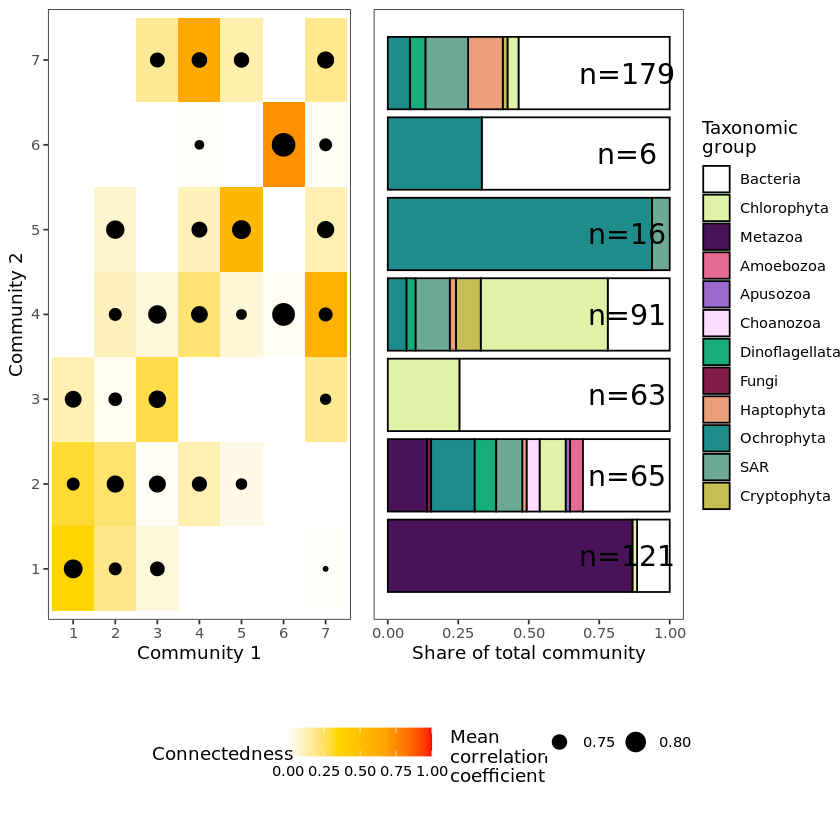

In [160]:
degree_strength

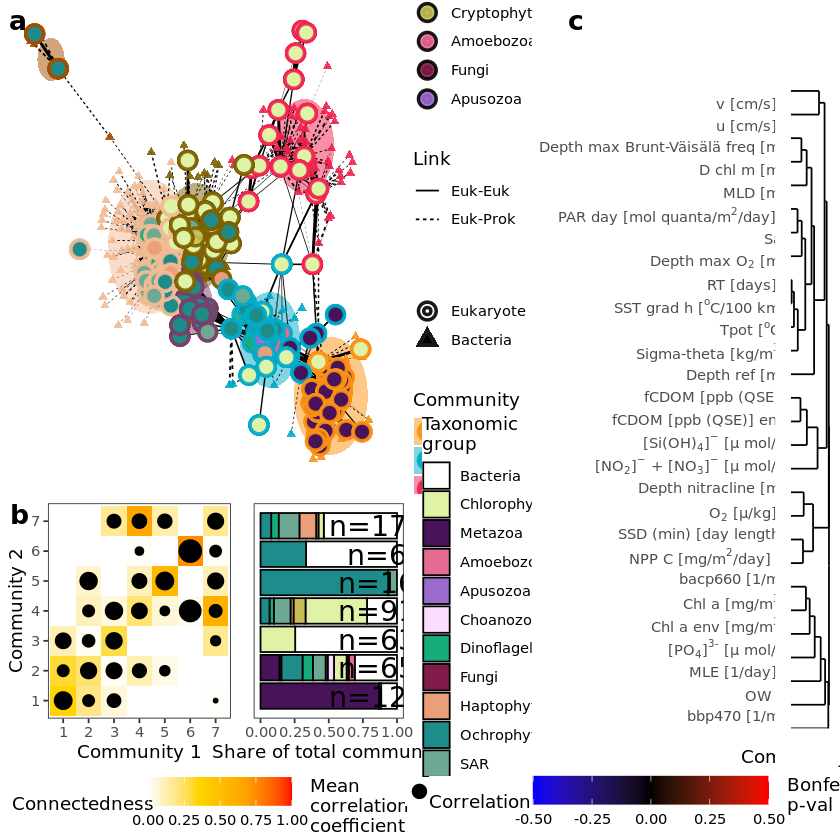

In [166]:
grid1 = cowplot::plot_grid(network_plot,degree_strength,nrow=2,rel_heights=c(1,0.7),labels=c("a","b"),label_size=16)
grid2 = cowplot::plot_grid(grid1,corr_comm_only_alldendro,nrow=1,rel_widths=c(1,0.5),labels=c("","c"),label_size=16) #,rel_heights=c(1,0.5))
grid2 
ggsave(file.path("..","figures","fig6_alexander_2021.png"),width=13,height=13,units="in",dpi=400)
ggsave(file.path("..","figures","fig6_alexander_2021.pdf"),width=14,height=13,units="in",dpi=400,useDingbats=FALSE)

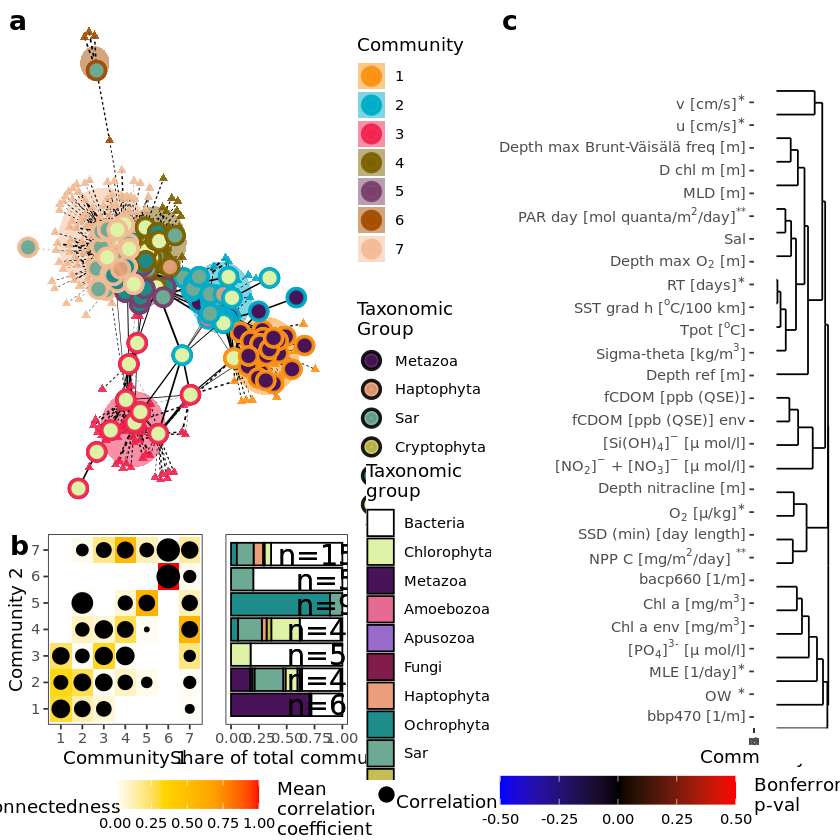

In [132]:
grid2

Look at the communities according to size fraction.s

In [190]:
current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,groups,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM)) & !is.na(community))

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.



Picking joint bandwidth of 2630

Picking joint bandwidth of 2770

Picking joint bandwidth of 5530

Picking joint bandwidth of 1980



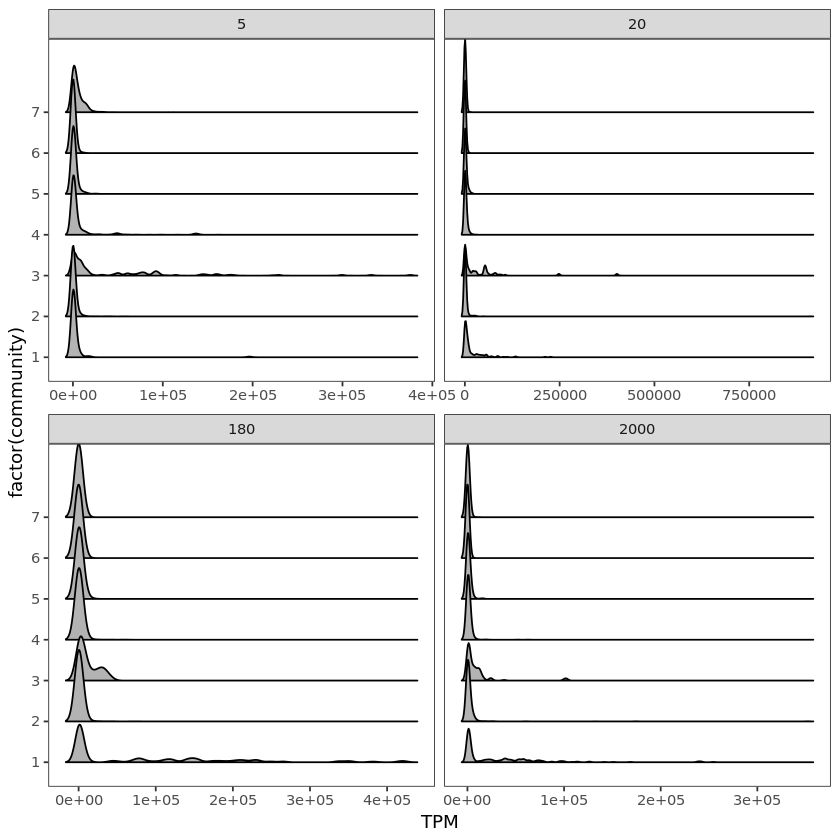

In [198]:
pacman::p_load(ggridges)
ggplot(current_df) + geom_density_ridges2(aes(x = TPM,y = factor(community))) + 
    facet_wrap(~factor(sf),scales="free_x") + 
    theme_test()

In [199]:
colnames(current_df)

[1] "Station"                                                            
 [2] "groups"                                                             
 [3] "community"                                                          
 [4] "TPM"                                                                
 [5] "study_accession"                                                    
 [6] "sample_accession"                                                   
 [7] "secondary_sample_accession"                                         
 [8] "experiment_accession"                                               
 [9] "tax_id"                                                             
[10] "scientific_name"                                                    
[11] "instrument_model"                                                   
[12] "library_layout"                                                     
[13] "read_count"                                                         
[14] "base_count"                                                         
[15] "experiment_title"                                                   
[16] "study_title"                                                        
[17] "experiment_alias"                                                   
[18] "run_alias"                                                          
[19] "fastq_bytes"                                                        
[20] "fastq_md5"                                                          
[21] "fastq_ftp"                                                          
[22] "submitted_ftp"                                                      
[23] "submitted_galaxy"                                                   
[24] "sra_ftp"                                                            
[25] "sra_galaxy"                                                         
[26] "cram_index_galaxy"                                                  
[27] "sample_alias"                                                       
[28] "sample_title"                                                       
[29] "TaraBarcode"                                                        
[30] "Basis"                                                              
[31] "Campaign"                                                           
[32] "Station (TARA_station#)"                                            
[33] "Event"                                                              
[34] "Event 2"                                                            
[35] "Method/Device"                                                      
[36] "Date/Time"                                                          
[37] "Latitude"                                                           
[38] "Longitude"                                                          
[39] "Date/Time 2"                                                        
[40] "Latitude 2"                                                         
[41] "Longitude 2"                                                        
[42] "Env feature (abbreviation)"                                         
[43] "Env feature (full name (ENVO:ID), terms re...)"                     
[44] "MP biome (Longhurst (2007))"                                        
[45] "Region"                                                             
[46] "BG province ([abbreviation] full name (MRG...)"                     
[47] "Depth ref [m] (in the selected environmental...)"                   
[48] "Cond [mS/cm] (in the selected environmental...)"                    
[49] "Sal"                                                                
[50] "Tpot [°C] (in the selected environmental...)"                       
[51] "Sigma-theta [kg/m**3] (in the selected environmental...)"           
[52] "O2 [µmol/kg] (in the selected environmental...)"                    
[53] "O2"                                                                 
[54] "Nitrate"            

`summarise()` has grouped output by 'Latitude', 'sf'. You can override using the `.groups` argument.

Warning message:
“Removed 7 rows containing missing values (geom_point).”


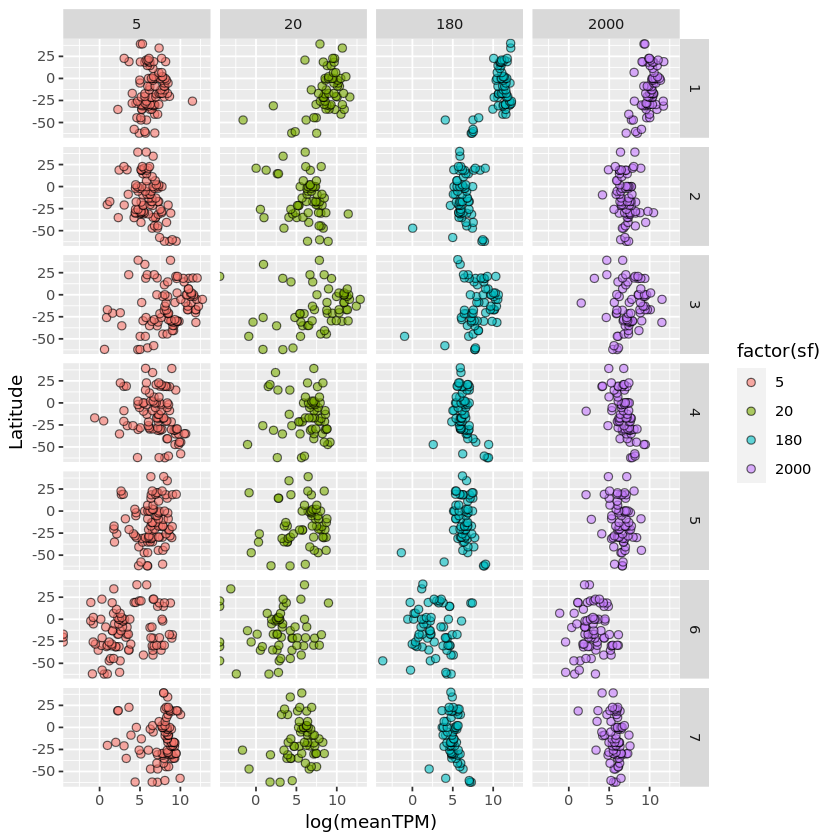

In [224]:
sf_com_lat = current_df %>% dplyr::group_by(Latitude,sf,community) %>% 
        dplyr::summarize(meanTPM = mean(TPM))
ggplot(sf_com_lat) + geom_point(aes(x = log(meanTPM), y = Latitude,
                                    fill = factor(sf)),pch=21,size=2, alpha = 0.6) + 
    facet_grid(rows=vars(community), cols = vars(sf))
    #facet_wrap(~community)

`summarise()` has grouped output by 'Latitude', 'sf'. You can override using the `.groups` argument.

Joining, by = "community"



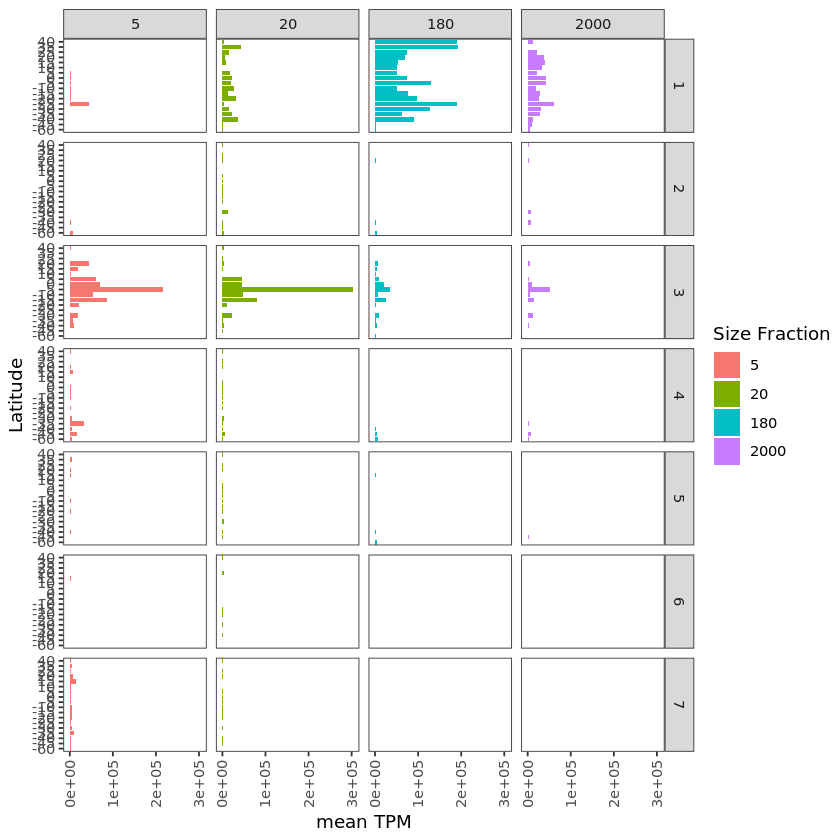

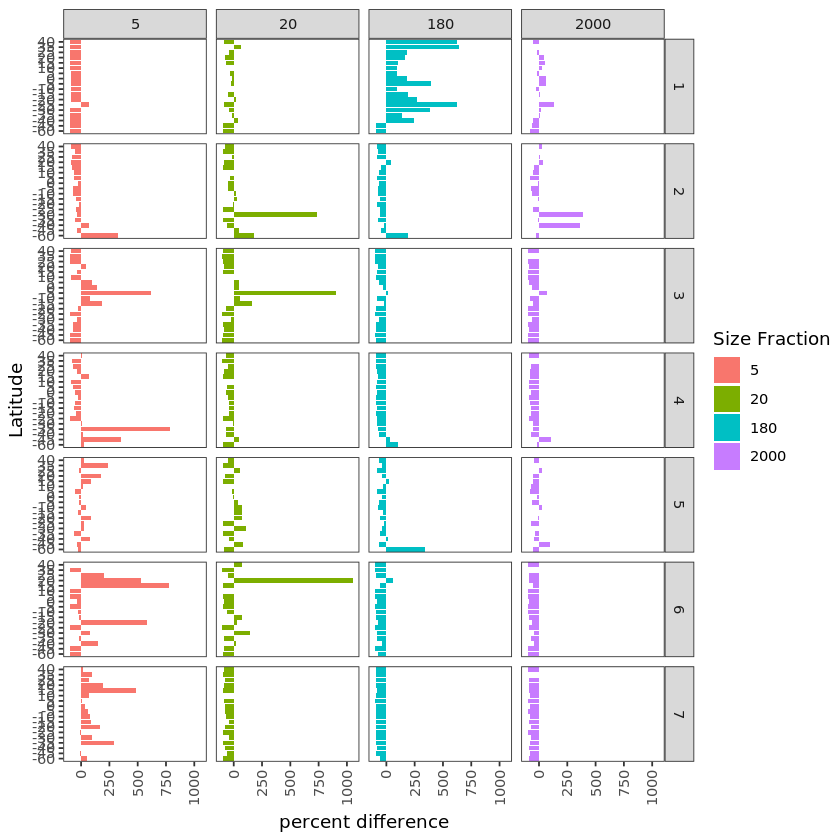

In [248]:
sf_com_lat = current_df %>% 
        dplyr::mutate(Latitude = round(Latitude/5)*5) %>%
        dplyr::group_by(Latitude,sf,community) %>% 
        dplyr::summarize(meanTPM = mean(TPM))

meanbycomm = current_df %>% dplyr::group_by(community) %>% 
        dplyr::summarize(overall_mean = mean(TPM))
sf_com_normal = sf_com_lat %>% dplyr::filter(!is.na(Latitude)) %>% dplyr::left_join(meanbycomm) %>%
    dplyr::mutate(meanTPMpercentdiff = (meanTPM - overall_mean) / overall_mean * 100)

ggplot(sf_com_lat%>% dplyr::filter(!is.na(Latitude))) + 
    geom_bar(aes(x = factor(round(Latitude/5)*5), y = meanTPM,
                                    fill = factor(sf)), stat = "identity") + 
    coord_flip() + theme_test() + xlab("Latitude") + ylab("mean TPM") + 
    scale_fill_discrete(name="Size Fraction") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    facet_grid(rows=vars(community), cols = vars(sf))
ggsave(file.path("..","si-figures","raw_numbers.png"),height=12,width=8,units="in")

ggplot(sf_com_normal) + 
    geom_bar(aes(x = factor(round(Latitude/5)*5), y = meanTPMpercentdiff,
                                    fill = factor(sf)), stat = "identity") + 
    coord_flip() + theme_test() + xlab("Latitude") + ylab("percent difference") + 
    scale_fill_discrete(name="Size Fraction") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    facet_grid(rows=vars(community), cols = vars(sf))
ggsave(file.path("..","si-figures","percent_diff.png"),height=12,width=8,units="in")